In [152]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMPORTS

In [153]:
from copy import deepcopy, copy
from hdbscan import all_points_membership_vectors, HDBSCAN
from matplotlib.axes import Axes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Optional
from umap import UMAP
from upsetplot import from_memberships, plot, UpSet, from_indicators, from_contents
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy


from project_modules.clustering import make_feature_importance_df, make_topN_features, make_plot_df

from project_modules.clustering import plot_feature_importances, plot_clusters, plot_multiple_features

# colour palette work
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [154]:
# parameters and dicts

# heatmap parameters
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}
# from the data dictionary
site_fullname_int_dict = {
                  1: "London",
                  2: "Montreal",
                  3: "San Diego",
                  4: "Rio de Janeiro",
                  5: "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [155]:
# input and output paths

figdir    = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir  = "../lc-project-data"

In [156]:
# timestamp for saving figures

import datetime as dt

timestamp = dt.datetime.now().strftime("%Y-%m-%d")
timestamp

# check to see if there is a subdirectory in figdir for the timestamp
import os

if not os.path.exists(os.path.join(figdir, timestamp)):
    os.makedirs(os.path.join(figdir, timestamp))

# redirect output to figdir/timestamp

figdir = os.path.join(figdir, timestamp)

print(figdir)

./OUTPUT/lc-pos-figures/2024-08-14


## FUNCTIONS

In [157]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [158]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [159]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

## LOAD DATA

In [160]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-05-05"

# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')

In [161]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [162]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

### Feature names and colours

In [163]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

103 features loaded.
90 colours loaded.


## LC+, LC-, HC

### Select which sets of features to use

In [164]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [165]:
LC_pos.shape, LC_neg.shape, HC.shape

((2194, 448), (3367, 448), (103, 448))

In [166]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

In [167]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))

SYMP 56
CD 244
MED 28
VAX 1
HHX 54
IMG 9
LAB 47
SUBS 5


# CLUSTERING

In [168]:
# clustering

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [169]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(2194, 246)
(2194, 246)


In [170]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

new_symptoms = []

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms + lc_symptoms
new_and_worse = lc_symptoms

In [171]:
# sort new_and_worse
new_and_worse = sorted(new_and_worse)

In [172]:
# drop SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

## Use UMAP to visualize the data and cluster

### Handling missing values

In [173]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

print(X.shape)

(2189, 245)


In [174]:
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

### EMBED and CLUSTER

In [175]:
# pipeline for scaling, embedding, and clustering 

# min cluster size scales as sqrt(n)
min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
                # 'metric': 'hamming',
            }

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# # TODO: move this to a function
# points   = pipe["embed"].embedding_
# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels


# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
# plot_df["Cluster"]            = [c+1 for c in clusters]
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"]               = sites

plot_df, cluster_labels = make_plot_df(pipe, 
                                        sites,
                                        site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100


UMAP(random_state=42, verbose=True)
Wed Aug 14 19:53:05 2024 Construct fuzzy simplicial set
Wed Aug 14 19:53:07 2024 Finding Nearest Neighbors
Wed Aug 14 19:53:07 2024 Finished Nearest Neighbor Search
Wed Aug 14 19:53:07 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 14 19:53:10 2024 Finished embedding


In [176]:
plot_df

x          y  Cluster  Cluster Confidence Site
0     10.886827  10.060935        4            0.921789  MTL
1      9.617863  11.725508        5            1.000000  MTL
2     11.869226  12.628811        5            0.000000  MTL
3      8.947426  11.094581        6            0.973296  MTL
4     11.997931  10.542110        4            0.982885  MTL
...         ...        ...      ...                 ...  ...
5659  11.894533   9.387194        4            0.981963  SAN
5660   9.636382   8.898794        7            0.000000  SAN
5661  12.070279   9.568502        4            0.995342  SAN
5662  11.912281  11.196840        5            0.863156  SAN
5663   8.858782   8.676079        7            0.000000  SAN

[2189 rows x 5 columns]

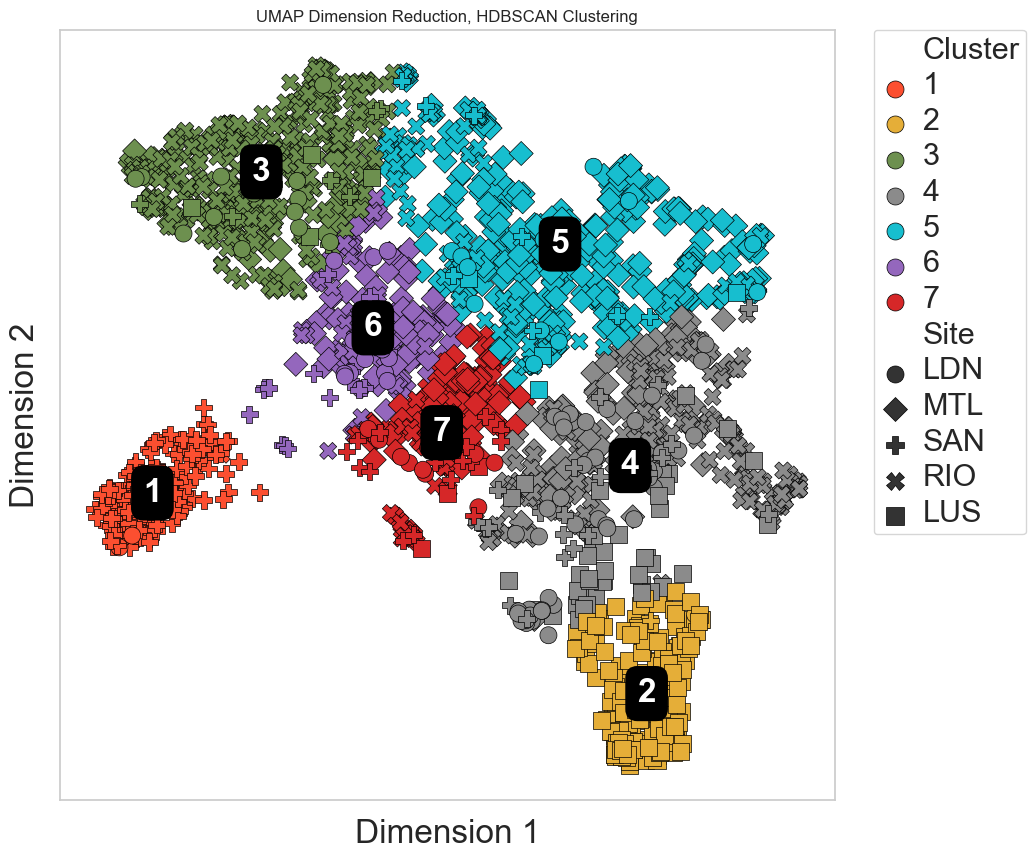

In [177]:
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title        = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids    = True, 
              size_by_prob = False, 
              ax           = None,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

In [178]:
# 2024-05-06
# redundant: recoded the erroneous records (21 MTL patients) to patient_type 99 to remove from the LC_pos and LC_neg datasets

# # find the indices of the points that x < 4
# idx = plot_df.query("x < 4").index
# idx

# # # read the records from "LC_POSITIVE_RECORD_IDS.csv"

# record_ids = pd.read_csv(f"{data_dir}/LC_POSITIVE_RECORD_IDS.csv", header = 0, index_col = 0)

# # # record_ids

# # # get the patient record_id that corresponds to idx
# record_ids.loc[idx]["record_id"].to_list()
# # # sns.heatmap(X.loc[idx].filter(regex = 'SYMPT').T, **heatmap_parms
# # # sns.heatmap(X.sample(20).filter(regex = 'SYMPT').T, **heatmap_parms)

#### Cluster by Site

In [179]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site.copy()

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# sort the index by the order in site_name_dict
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0


In [180]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/basic-cluster-by-site.tex")

In [181]:
c1 = plot_df.groupby("Cluster")["Site"].value_counts(normalize = True).unstack().T.fillna(0)#.astype(int)
c1 = c1.loc[site_name_dict.values()]
c1

Cluster         1         2         3         4         5         6         7
Site                                                                         
LDN      0.010309  0.004651  0.032110  0.113978  0.023857  0.089947  0.058824
MTL      0.000000  0.000000  0.172018  0.352688  0.793241  0.687831  0.679144
SAN      0.984536  0.004651  0.018349  0.047312  0.017893  0.084656  0.101604
RIO      0.005155  0.000000  0.768349  0.391398  0.157058  0.137566  0.144385
LUS      0.000000  0.990698  0.009174  0.094624  0.007952  0.000000  0.016043

#### RFC Model to identify features that differentiate clusters

In [182]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	37
Tentative: 	0
Rejected: 	208


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=124,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x32058C940),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x32058C940,
         verbose=1)

In [183]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=124, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x32058C940)

In [184]:
fi_df1 = make_feature_importance_df(clf, important_features)
features20 = make_topN_features(fi_df1, 20, feature_map, feature_colour_map)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


./OUTPUT/lc-pos-figures/2024-08-14/cluster-features-600-2024-08-14.png
./OUTPUT/lc-pos-figures/2024-08-14/cluster-features-300-2024-08-14.png


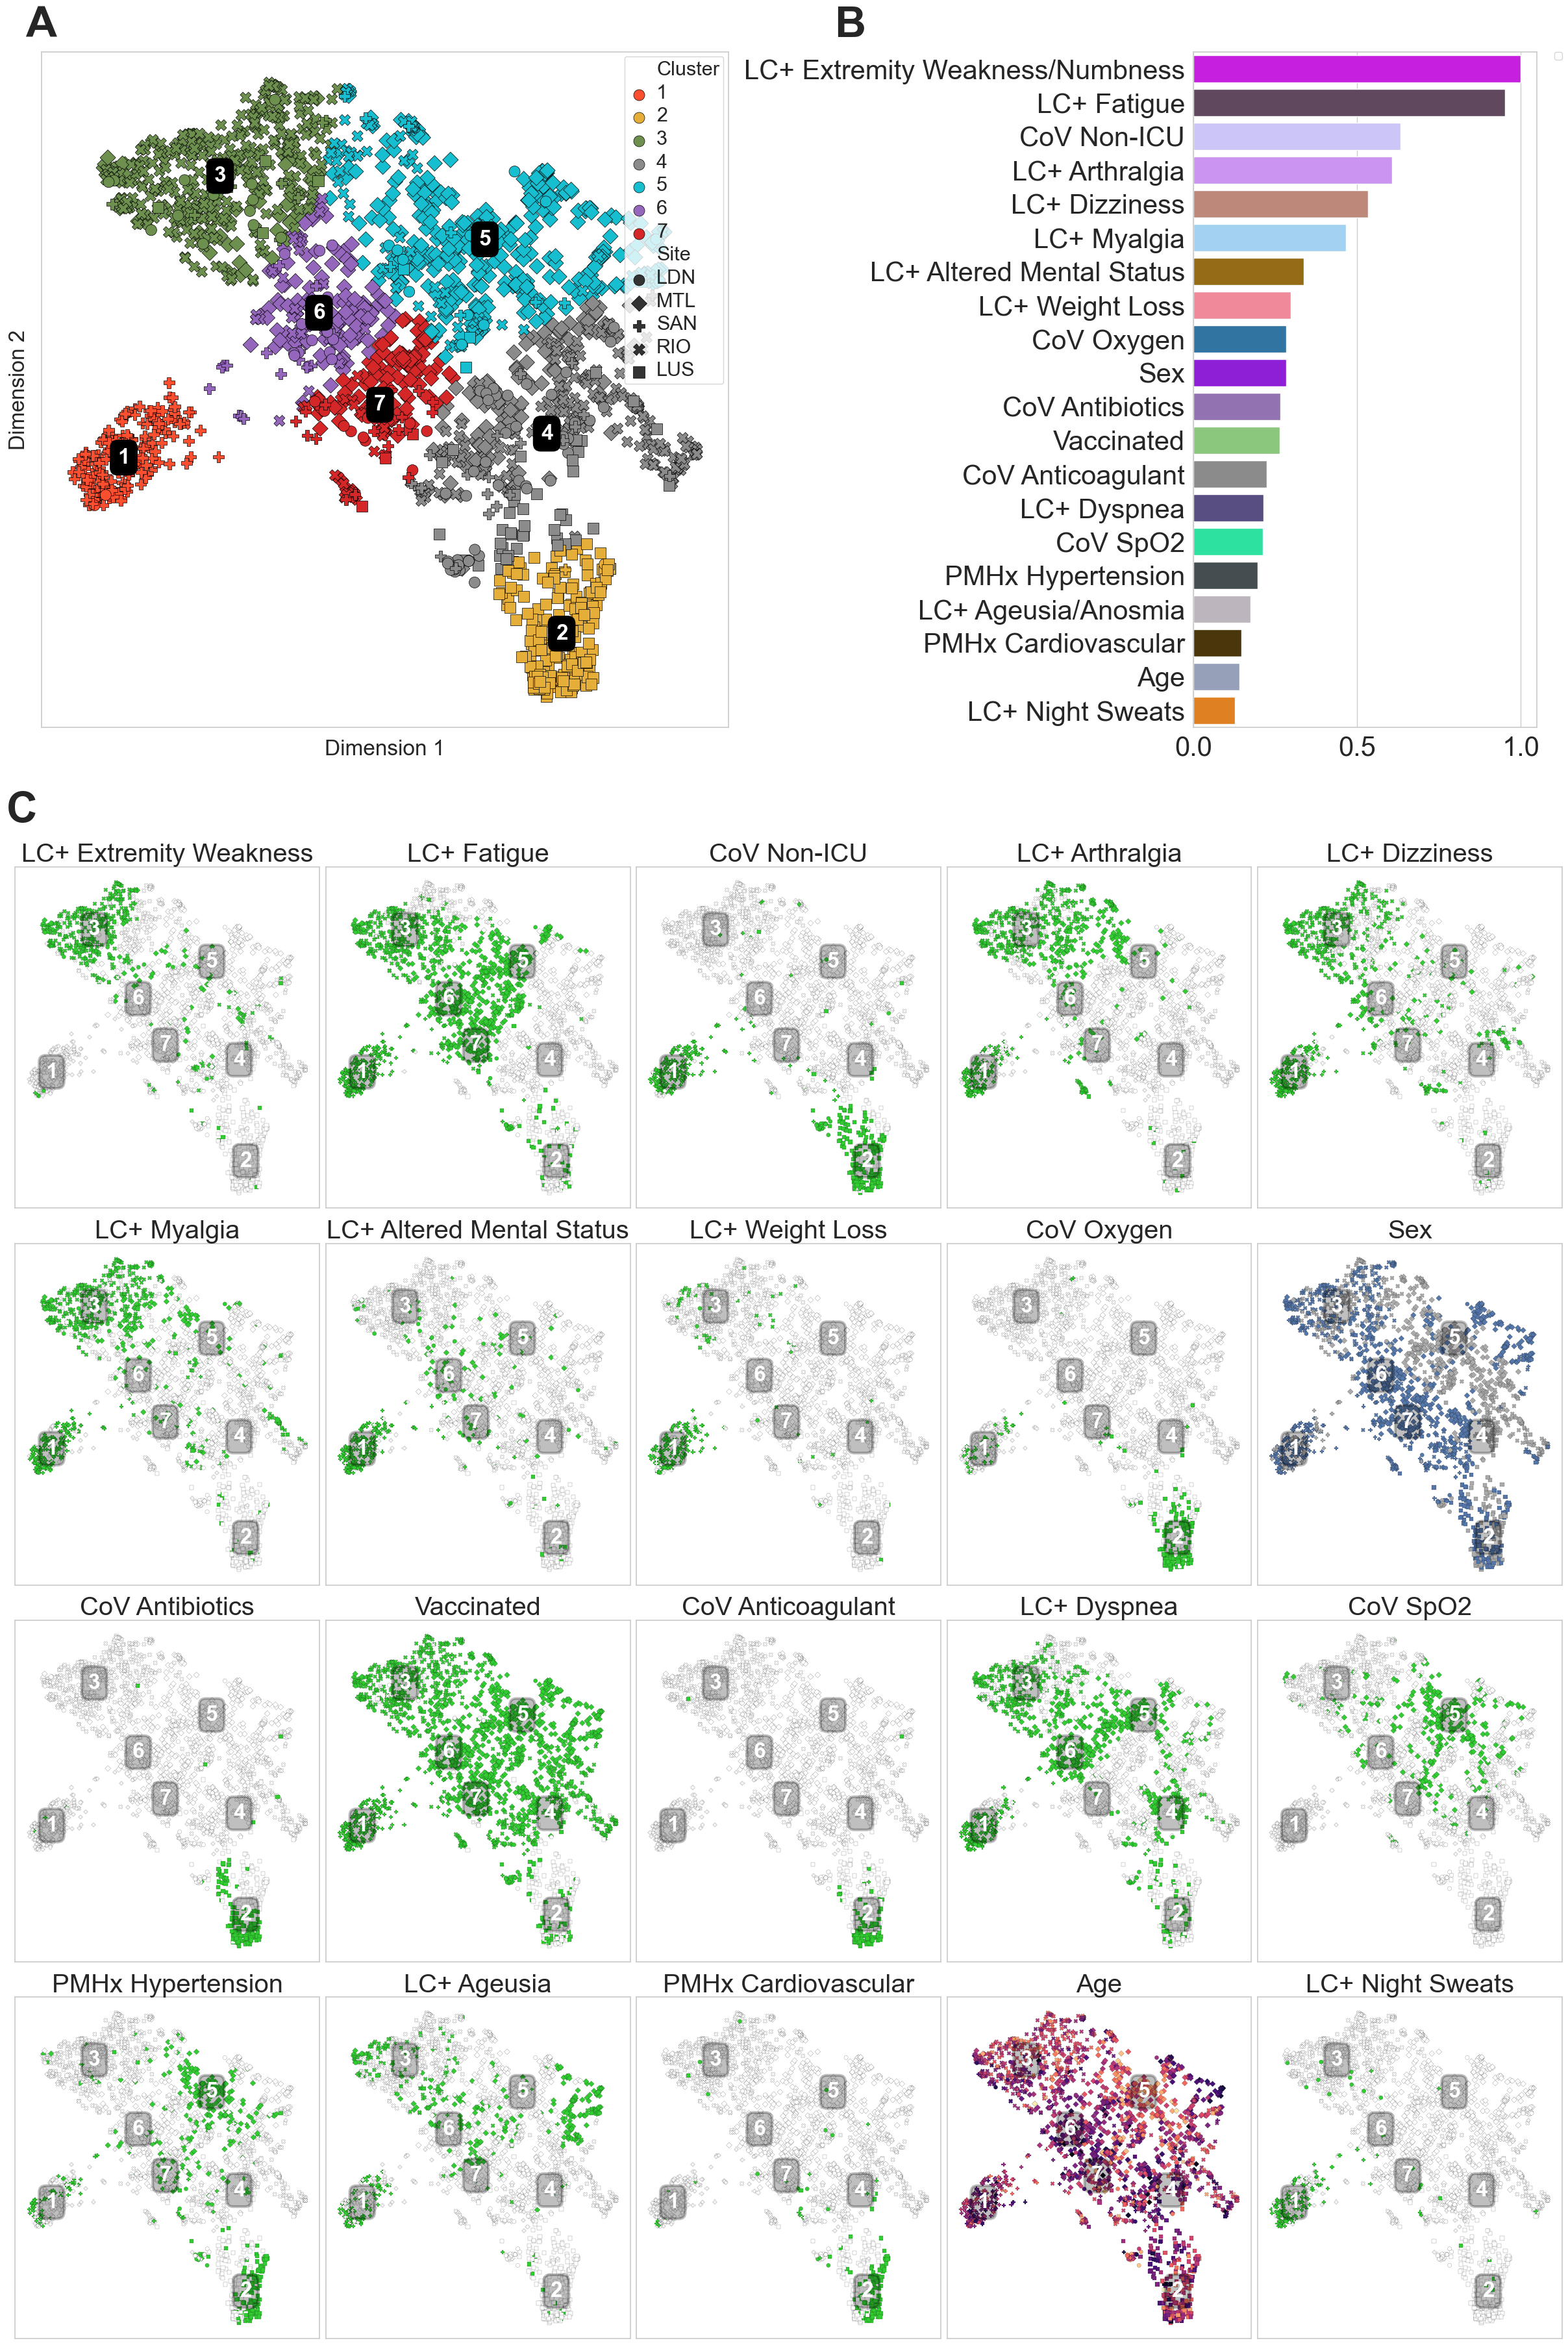

In [185]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, palette_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )

plot_feature_importances(features20, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(fi_df1, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        fontsize = FONTSIZE*1.2,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:

    for dpi in [600, 300]:

        fn = f"{figdir}/cluster-features-{dpi}-{timestamp}.png"
        print(fn)
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances-600.png", dpi = 600, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances-300.png", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [186]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# fi_df = make_feature_importance_df(clf, important_features)

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [187]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [188]:
cluster_by_site

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0

In [189]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

cbsm

cluster            1     2     3     4     5     6     7
Site                                                    
London           1.8   0.9  12.7  48.2  10.9  15.5  10.0
Montreal         0.0   0.0   8.4  18.3  44.6  14.5  14.2
San Diego       71.8   0.4   3.0   8.3   3.4   6.0   7.1
Rio de Janeiro   0.2   0.0  51.5  28.0  12.2   4.0   4.2
Lusaka           0.0  79.5   1.5  16.4   1.5   0.0   1.1

In [190]:
zzz = M.groupby("cluster").mean()

# get the first 20 columns
zzz = zzz[fff["Feature"][:20]]

# rename the columns
for c in zzz.columns:
    zzz.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
zzz = zzz.drop(columns = ["Age", "Sex"])

In [191]:
zzz

LC+ Extremity Weakness/Numbness  LC+ Fatigue  CoV Non-ICU  \
cluster                                                              
1                               0.020619     0.989691     0.927835   
2                               0.018605     0.167442     0.790698   
3                               0.805046     0.779817     0.013761   
4                               0.073118     0.068817     0.122581   
5                               0.063618     0.544732     0.013917   
6                               0.116402     0.968254     0.074074   
7                               0.053476     0.844920     0.032086   

         LC+ Arthralgia  LC+ Dizziness  LC+ Myalgia  \
cluster                                               
1              0.747423       0.840206     0.845361   
2              0.046512       0.041860     0.051163   
3              0.786697       0.736239     0.795872   
4              0.015054       0.118280     0.126882   
5              0.254473       0.097416     0.180915   
6              0.243386       0.280423     0.227513   
7              0.197861       0.117647     0.085561   

         LC+ Altered Mental Status  LC+ Weight Loss  CoV Oxygen  \
cluster                                                           
1                         0.902062         0.768041    0.237113   
2                         0.041860         0.009302    0.706977   
3                         0.052752         0.096330    0.006881   
4                         0.038710         0.012903    0.027957   
5                         0.047714         0.017893    0.000000   
6                         0.232804         0.010582    0.010582   
7                         0.122995         0.016043    0.026738   

         CoV Antibiotics  Vaccinated  CoV Anticoagulant  LC+ Dyspnea  \
cluster                                                                
1               0.015464    0.953608           0.000000     0.737113   
2               0.632558    0.223256           0.520930     0.209302   
3               0.002294    0.938073           0.002294     0.628440   
4               0.036559    0.903226           0.002151     0.322581   
5               0.003976    0.978131           0.001988     0.399602   
6               0.000000    0.978836           0.000000     0.878307   
7               0.000000    0.957219           0.000000     0.037433   

         CoV SpO2  PMHx Hypertension  LC+ Ageusia/Anosmia  \
cluster                                                     
1        0.000000           0.309278             0.494845   
2        0.000000           0.567442             0.046512   
3        0.082569           0.036697             0.293578   
4        0.083871           0.103226             0.083871   
5        0.401590           0.349901             0.294235   
6        0.121693           0.089947             0.264550   
7        0.192513           0.213904             0.144385   

         PMHx Cardiovascular  LC+ Night Sweats  
cluster                                         
1                   0.030928          0.613402  
2                   0.548837          0.023256  
3                   0.009174          0.022936  
4                   0.034409          0.010753  
5                   0.007952          0.001988  
6                   0.000000          0.037037  
7                   0.042781          0.026738

./OUTPUT/lc-pos-figures/2024-08-14/feature-prevalence-by-cluster-600-2024-08-14.png
./OUTPUT/lc-pos-figures/2024-08-14/feature-prevalence-by-cluster-300-2024-08-14.png


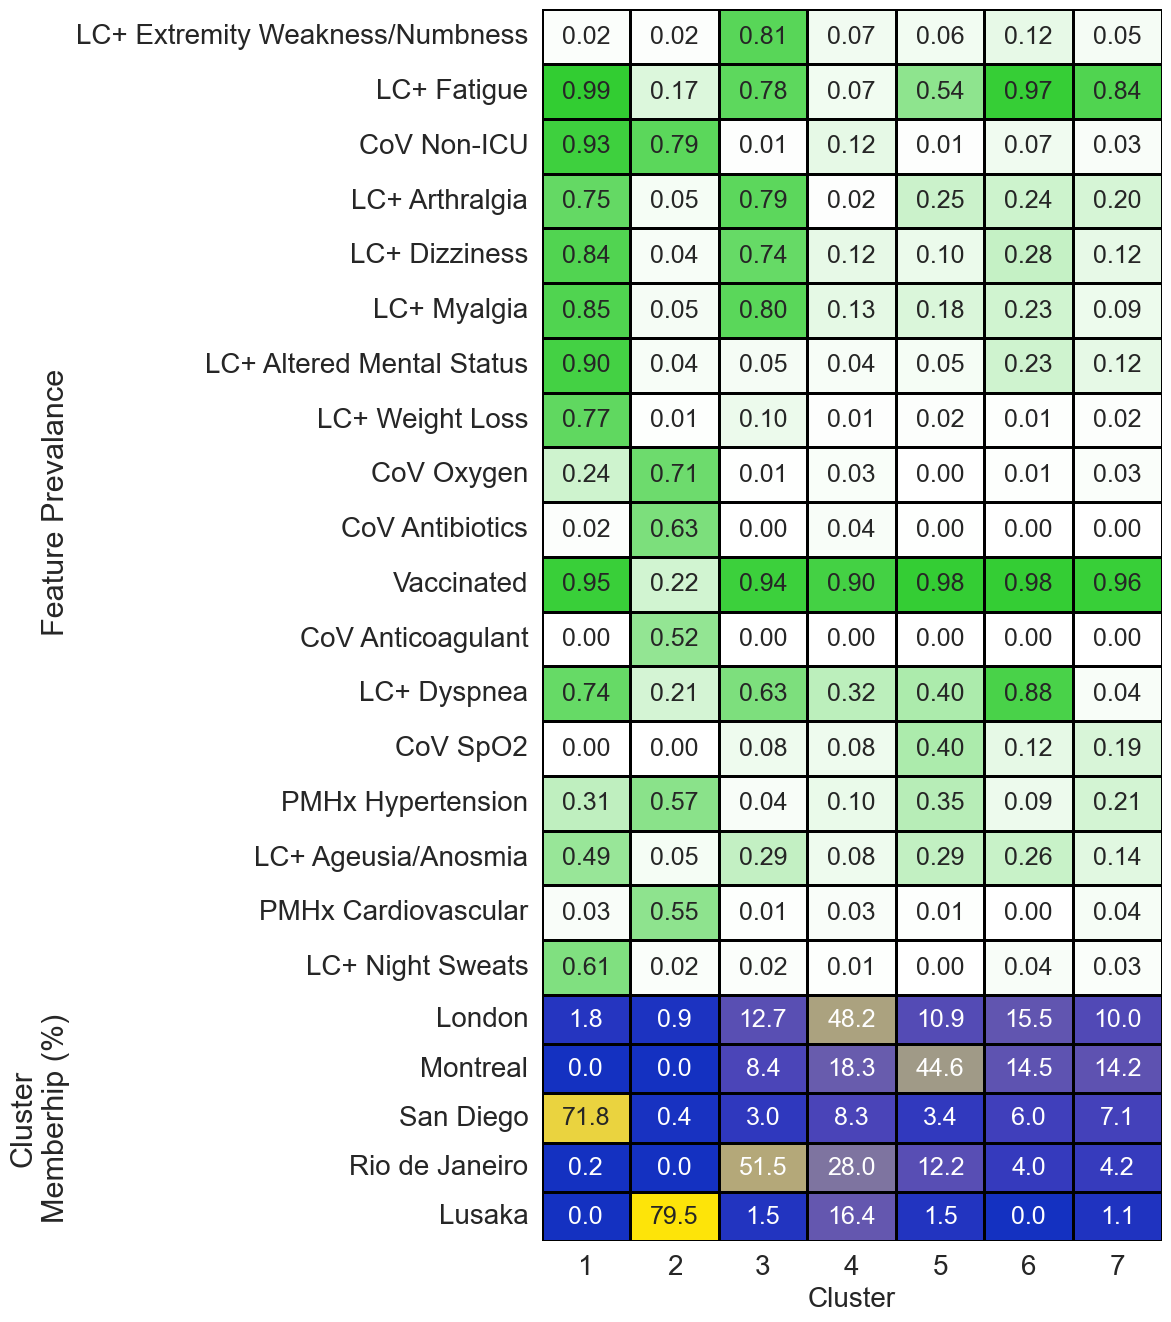

In [192]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(zzz.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
# plt.savefig(f"{figdir}/feature-prevalence-by-cluster-600.png", dpi = 600, bbox_inches = 'tight')
# plt.savefig(f"{figdir}/feature-prevalence-by-cluster-300.png", dpi = 300, bbox_inches = 'tight')

for dpi in [600, 300]:

    fn = f"{figdir}/feature-prevalence-by-cluster-{dpi}-{timestamp}.png"
    print(fn)
    plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


### UPSET PLOTS

In [193]:
# A["SITE"] = LC_pos_["SITE"]
# II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# # get column names and index names from X 
# II.columns = X.columns
# II.index   = X.index


# # A.shape, X.shape, II.shape
# # vv = A.drop("cluster", axis = 1)
# B = II.copy()

# # augment with site labels
# B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# interesting = list(fff["Feature"][:5])
# upset_A = make_upset_data(A, 
#                        interesting, 
#                        )

# upset_data = make_upset_data(B, 
#                                 interesting, 
#                                 keep_features = True
#                                 )

# indicators_bool = upset_data.select_dtypes(include = ['bool'])
# us = UpSet(
#     from_indicators(indicators_bool, data = upset_data),
#     min_subset_size=15,
#     # max_subset_size=200,
#     show_counts                = True,
#     sort_categories_by         = "-input",
#     subset_size                = "count",
#     intersection_plot_elements = 0,
#     orientation                = "horizontal",
# )

# # us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

# us.add_stacked_bars(by="SITE", 
#                        title="Count SITE", 
#                        elements=10, 
#                        colors = cc.m_glasbey_hv, 
#                        )

# us.plot()
# plt.show()

In [194]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

In [195]:
# from scipy.stats import chi2_contingency

# rd = {}

# for site1 in site_name_dict.values():

#     for site2 in site_name_dict.values():

#         for col in X.columns:

#             # get the index of rows where SITE is site1 or site2
#             idx = LC_pos_["SITE"].isin([site1, site2])

#             print(idx)

#             ct = pd.crosstab(LC_pos_.loc[idx]["SITE"], X.loc[idx][col]).rename(index = site_name_dict)


#             print(ct)

#             result = chi2_contingency(ct)
#             if result[1] < 0.05:
#                 # print(ct)
#                 print(f"{site}: \t{col} --> p = {result[1]}")
#                 rd.update({site: result[1]})


# # for col in X.columns:


# #     ct = pd.crosstab(LC_pos_["SITE"], X[col]).rename(index = site_name_dict)

# #     result = chi2_contingency(ct)
# #     if result[1] < 0.05:
# #         # print(ct)
# #         # print(f"{col}: p = {result[1]}")
# #         rd.update({col: result[1]})

# # # make dataframe from rd
# # rd_df = pd.DataFrame.from_dict(rd, orient = "index", columns = ["p-value"])

# # # sort by p-value
# # rd_df.sort_values(by = "p-value", inplace = True, ascending = False)
# # rd_df

# By SITE for subphenotypes at each site

In [196]:
# select the columns to use
LC_COLUMNS = LC_pos_.columns

# remove SITE from LC_COLUMNS
LC_COLUMNS = LC_COLUMNS.drop(["SITE", "age"])

In [197]:
# cluster pipeline, iterating over the sites

result_dict = {}

for i, (k,v) in enumerate(site_name_dict.items()):
    # print(i, k, v)

    print(f"Site {k}: {v}")

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE == {k}").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])


    X = scaler.fit_transform(the_data)     # type: ignore
    X = X.dropna(axis = 0)
    X = X[LC_COLUMNS]

    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    min_cluster_size = int(np.sqrt(X.shape[0]))

    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    'spread':       1.0,
                    'random_state': 42,
                    # 'metric':      'euclidean',
                    # 'metric':      'hamming',
                    'verbose':      False
                }

    # turn off userwarnings from umap
    import warnings
    warnings.filterwarnings("ignore")
    
    # instantiate the pipeline
    pipe = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('embed', UMAP(**umap_parms)),
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)

    # get the plot dataframe and cluster labels
    sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
    plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

    # what fraction of the data is in each cluster?
    # print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 100
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]
    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                 'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,
                 }

    result_dict.update({v: case_dict})

# plt.show()

Site 1: LDN
Data shape = (110, 245)
X shape    = (110, 244)
Site 2: MTL
Data shape = (895, 245)
X shape    = (895, 244)
Site 3: SAN
Data shape = (266, 245)
X shape    = (266, 244)
Site 4: RIO
Data shape = (651, 245)
X shape    = (650, 244)
Site 5: LUS
Data shape = (272, 245)
X shape    = (272, 244)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


./OUTPUT/lc-pos-figures/2024-08-14/subphenotype-feature-importances-by-site-600-2024-08-14.png
./OUTPUT/lc-pos-figures/2024-08-14/subphenotype-feature-importances-by-site-300-2024-08-14.png


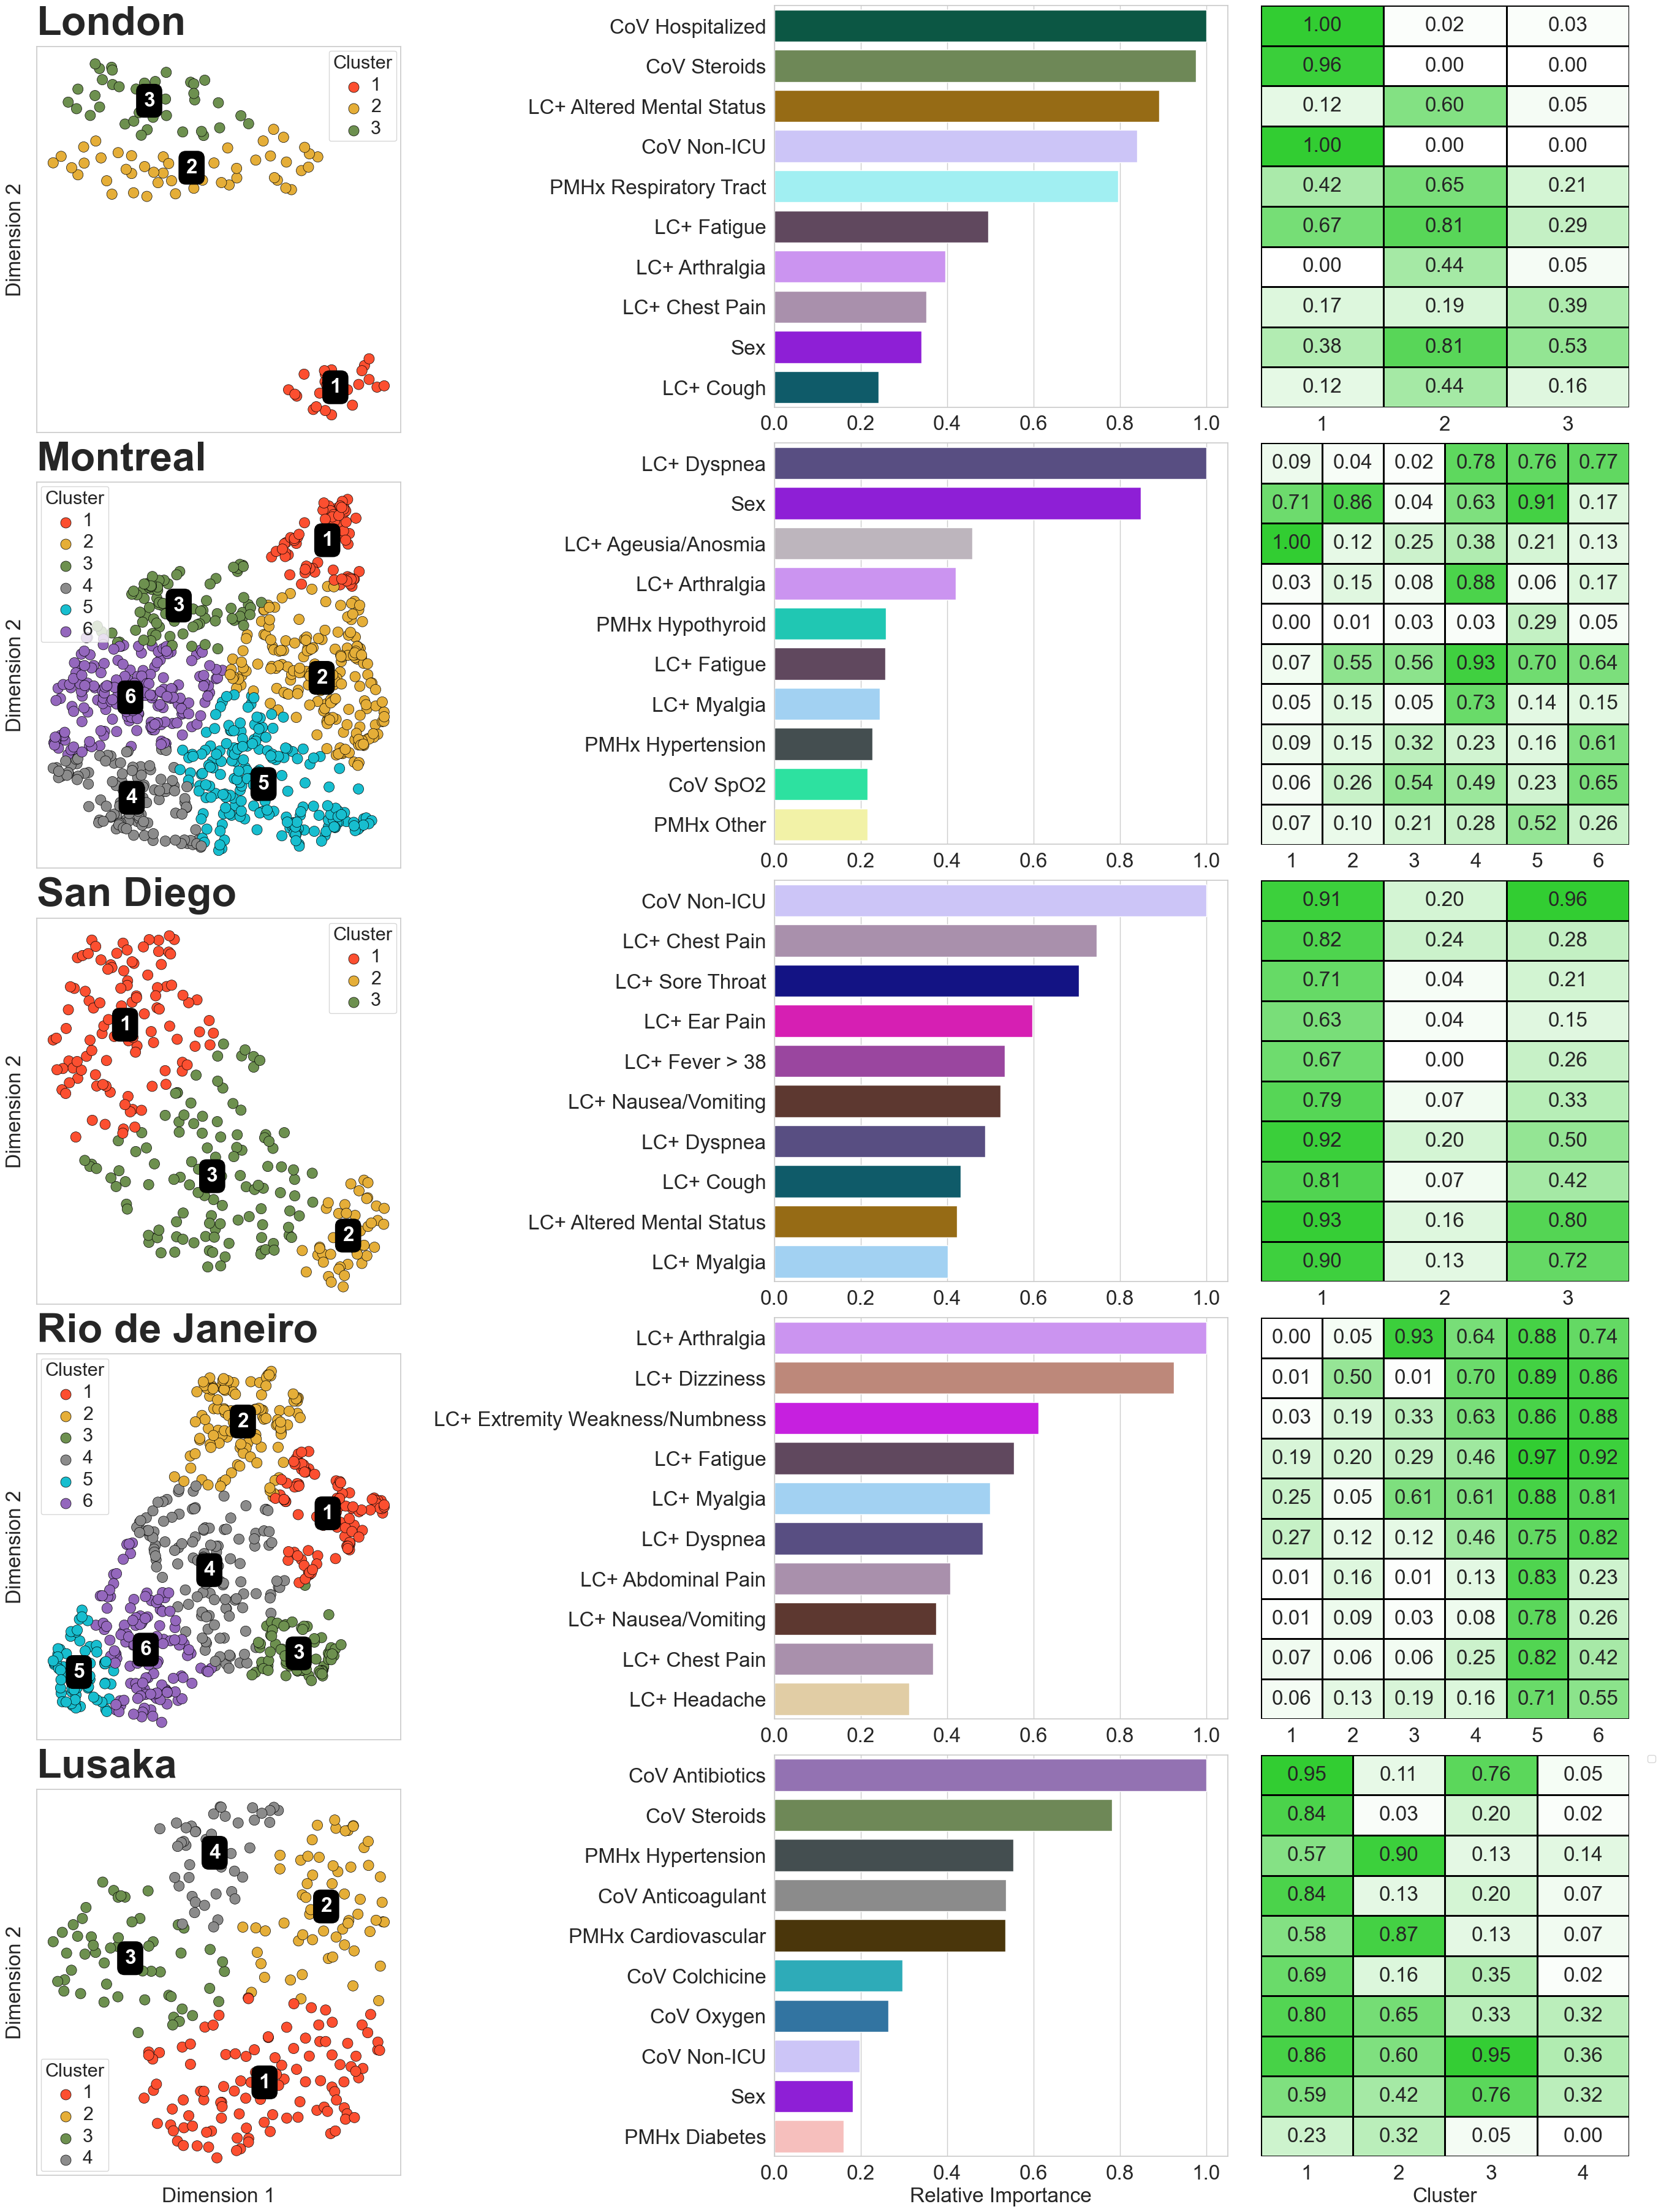

In [198]:
# make the figure

fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

axl = subfigs[0].subplots(5, 1)
axc = subfigs[1].subplots(5, 1, sharex = False)
axr = subfigs[2].subplots(5, 1, sharex = False)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X                  = v['X']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  palette_dict,
                  title        = None, 
                  centroids    = True, 
                  size_by_prob = False, 
                  ax           = axl[i], 
                  style        = None
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_feature_importance_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_topN_features(fi_df, 
                                    10, 
                                    feature_map, 
                                    feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)

    # the mean feature values
    mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

for dpi in [600, 300]:

    fn = f"{figdir}/subphenotype-feature-importances-by-site-{dpi}-{timestamp}.png"
    print(fn)
    plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


# plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-300.png", dpi = 300, bbox_inches = 'tight')
# plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-600.png", dpi = 600, bbox_inches = 'tight')


# By SYMPTOM Status
- new, worsening, etc

In [199]:

factor = 3

In [200]:
lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

In [201]:
# select only the features in new_and_worse
X = LC_pos_[lc_symptoms].copy()
print(X.shape)

# drop rows with missing values
X.dropna(inplace = True, axis = 0)
print(X.shape)

# drop rows with all zeros
# X = X.loc[(X != 0).any(axis = 1)]
print(X.shape)

(2194, 28)
(2194, 28)
(2194, 28)


In [202]:
# drop certain features

# drop features that contain adjunctive
X = X.drop(columns = X.filter(regex = 'adjunctive').columns)

# drop features that contain "medication_received"
X = X.drop(columns = X.filter(regex = 'medication_received').columns)

# drop features that contain "type_of_care"
X = X.drop(columns = X.filter(regex = 'type_of_care').columns)

# drop features that contain "ventilatory_support_type"
X = X.drop(columns = X.filter(regex = 'ventilatory_support_type').columns)

print(X.shape)

(2194, 28)


In [203]:
# cluster pipeline


min_cluster_size = int(np.sqrt(X.shape[0]))*factor

print(f"MCS = {min_cluster_size}")



hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples':      min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.5,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
                'min_dist':     0.25,
                # 'metric': 'cosine',
                # 'metric': 'hamming',
            }

# define the transformer
umap_transformer = UMAP(**umap_parms, verbose = True)
embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', embedding_model),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# get the dataframe and the labels
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

n_clust = max(cluster_labels)+1

MCS = 138
UMAP(min_dist=0.25, random_state=42, verbose=True)
Wed Aug 14 19:54:54 2024 Construct fuzzy simplicial set
Wed Aug 14 19:54:56 2024 Finding Nearest Neighbors
Wed Aug 14 19:54:56 2024 Finished Nearest Neighbor Search
Wed Aug 14 19:54:56 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 14 19:55:02 2024 Finished embedding


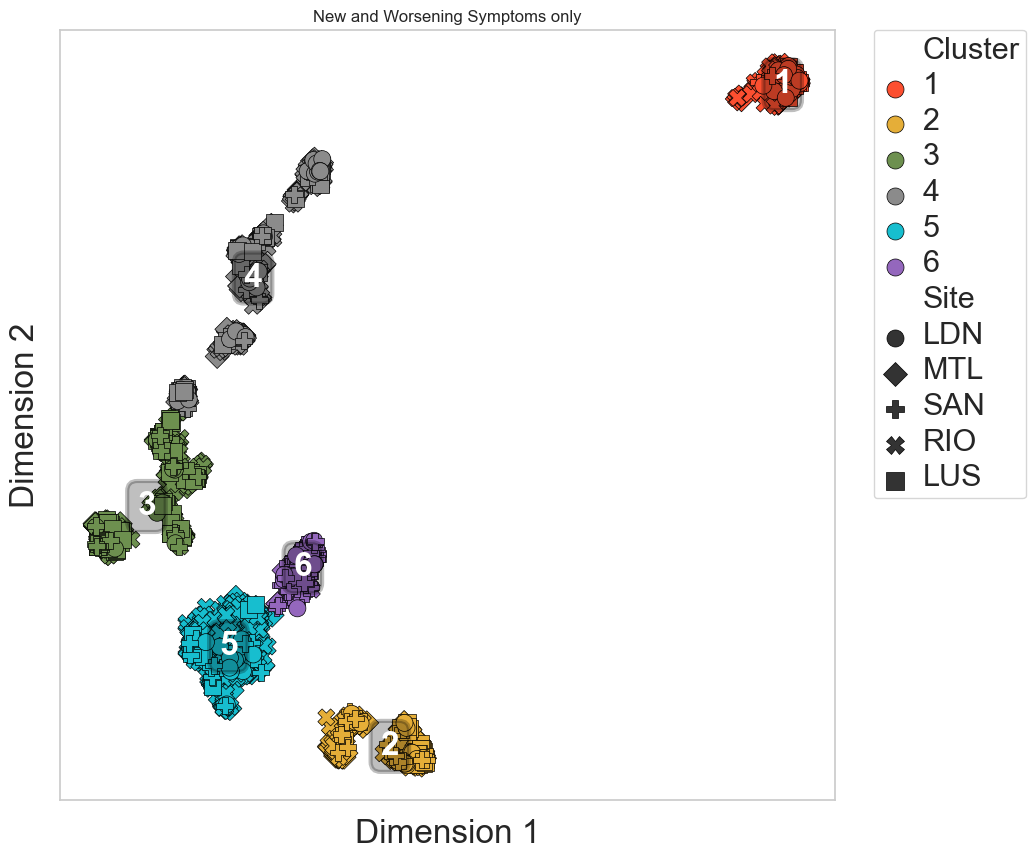

In [204]:
# plot the clusters
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = f"New and Worsening Symptoms only", 
              centroids = True, 
              size_by_prob = False, 
              ax = None,
              centroid_kws = {"alpha": 0.25, "palette_dict":None, "show_edge": False},)


In [205]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

In [206]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/SYMPT_2-cluster-by-site-{n_clust}.tex")

In [207]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

# sort by the order in site_name_dict
cbsm = cbsm.loc[site_fullname_dict.values()]

cbsm

cluster            1     2     3     4     5     6
Site                                              
London          19.1  15.5   9.1  37.3  10.9   8.2
Montreal        17.2  22.3  12.0  30.4  17.7   0.4
San Diego        2.6   7.5   7.1   5.6   6.0  71.1
Rio de Janeiro   4.1   5.5  26.3  11.1  52.8   0.2
Lusaka           4.0  13.2  44.9  35.3   2.6   0.0

In [208]:
# find important features

# classifier
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# boruta
boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )

# fit, with the cluster_labels as targets
boruta.fit(X, cluster_labels)

# get the important features
important_features = X.columns[boruta.support_]

# now fit the classifier on these features
clf2.fit(X[important_features], cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

RandomForestClassifier(max_depth=7, n_estimators=96, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x313223840)

In [209]:
# dataframes with the feature importance and topN features
fi_df = make_feature_importance_df(clf2, important_features)
top_features = make_topN_features(fi_df, 20, feature_map, feature_colour_map)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


./OUTPUT/lc-pos-figures/2024-08-14/SYMPT_2-only-feature-importances-600-6-2024-08-14.png
./OUTPUT/lc-pos-figures/2024-08-14/SYMPT_2-only-feature-importances-300-6-2024-08-14.png


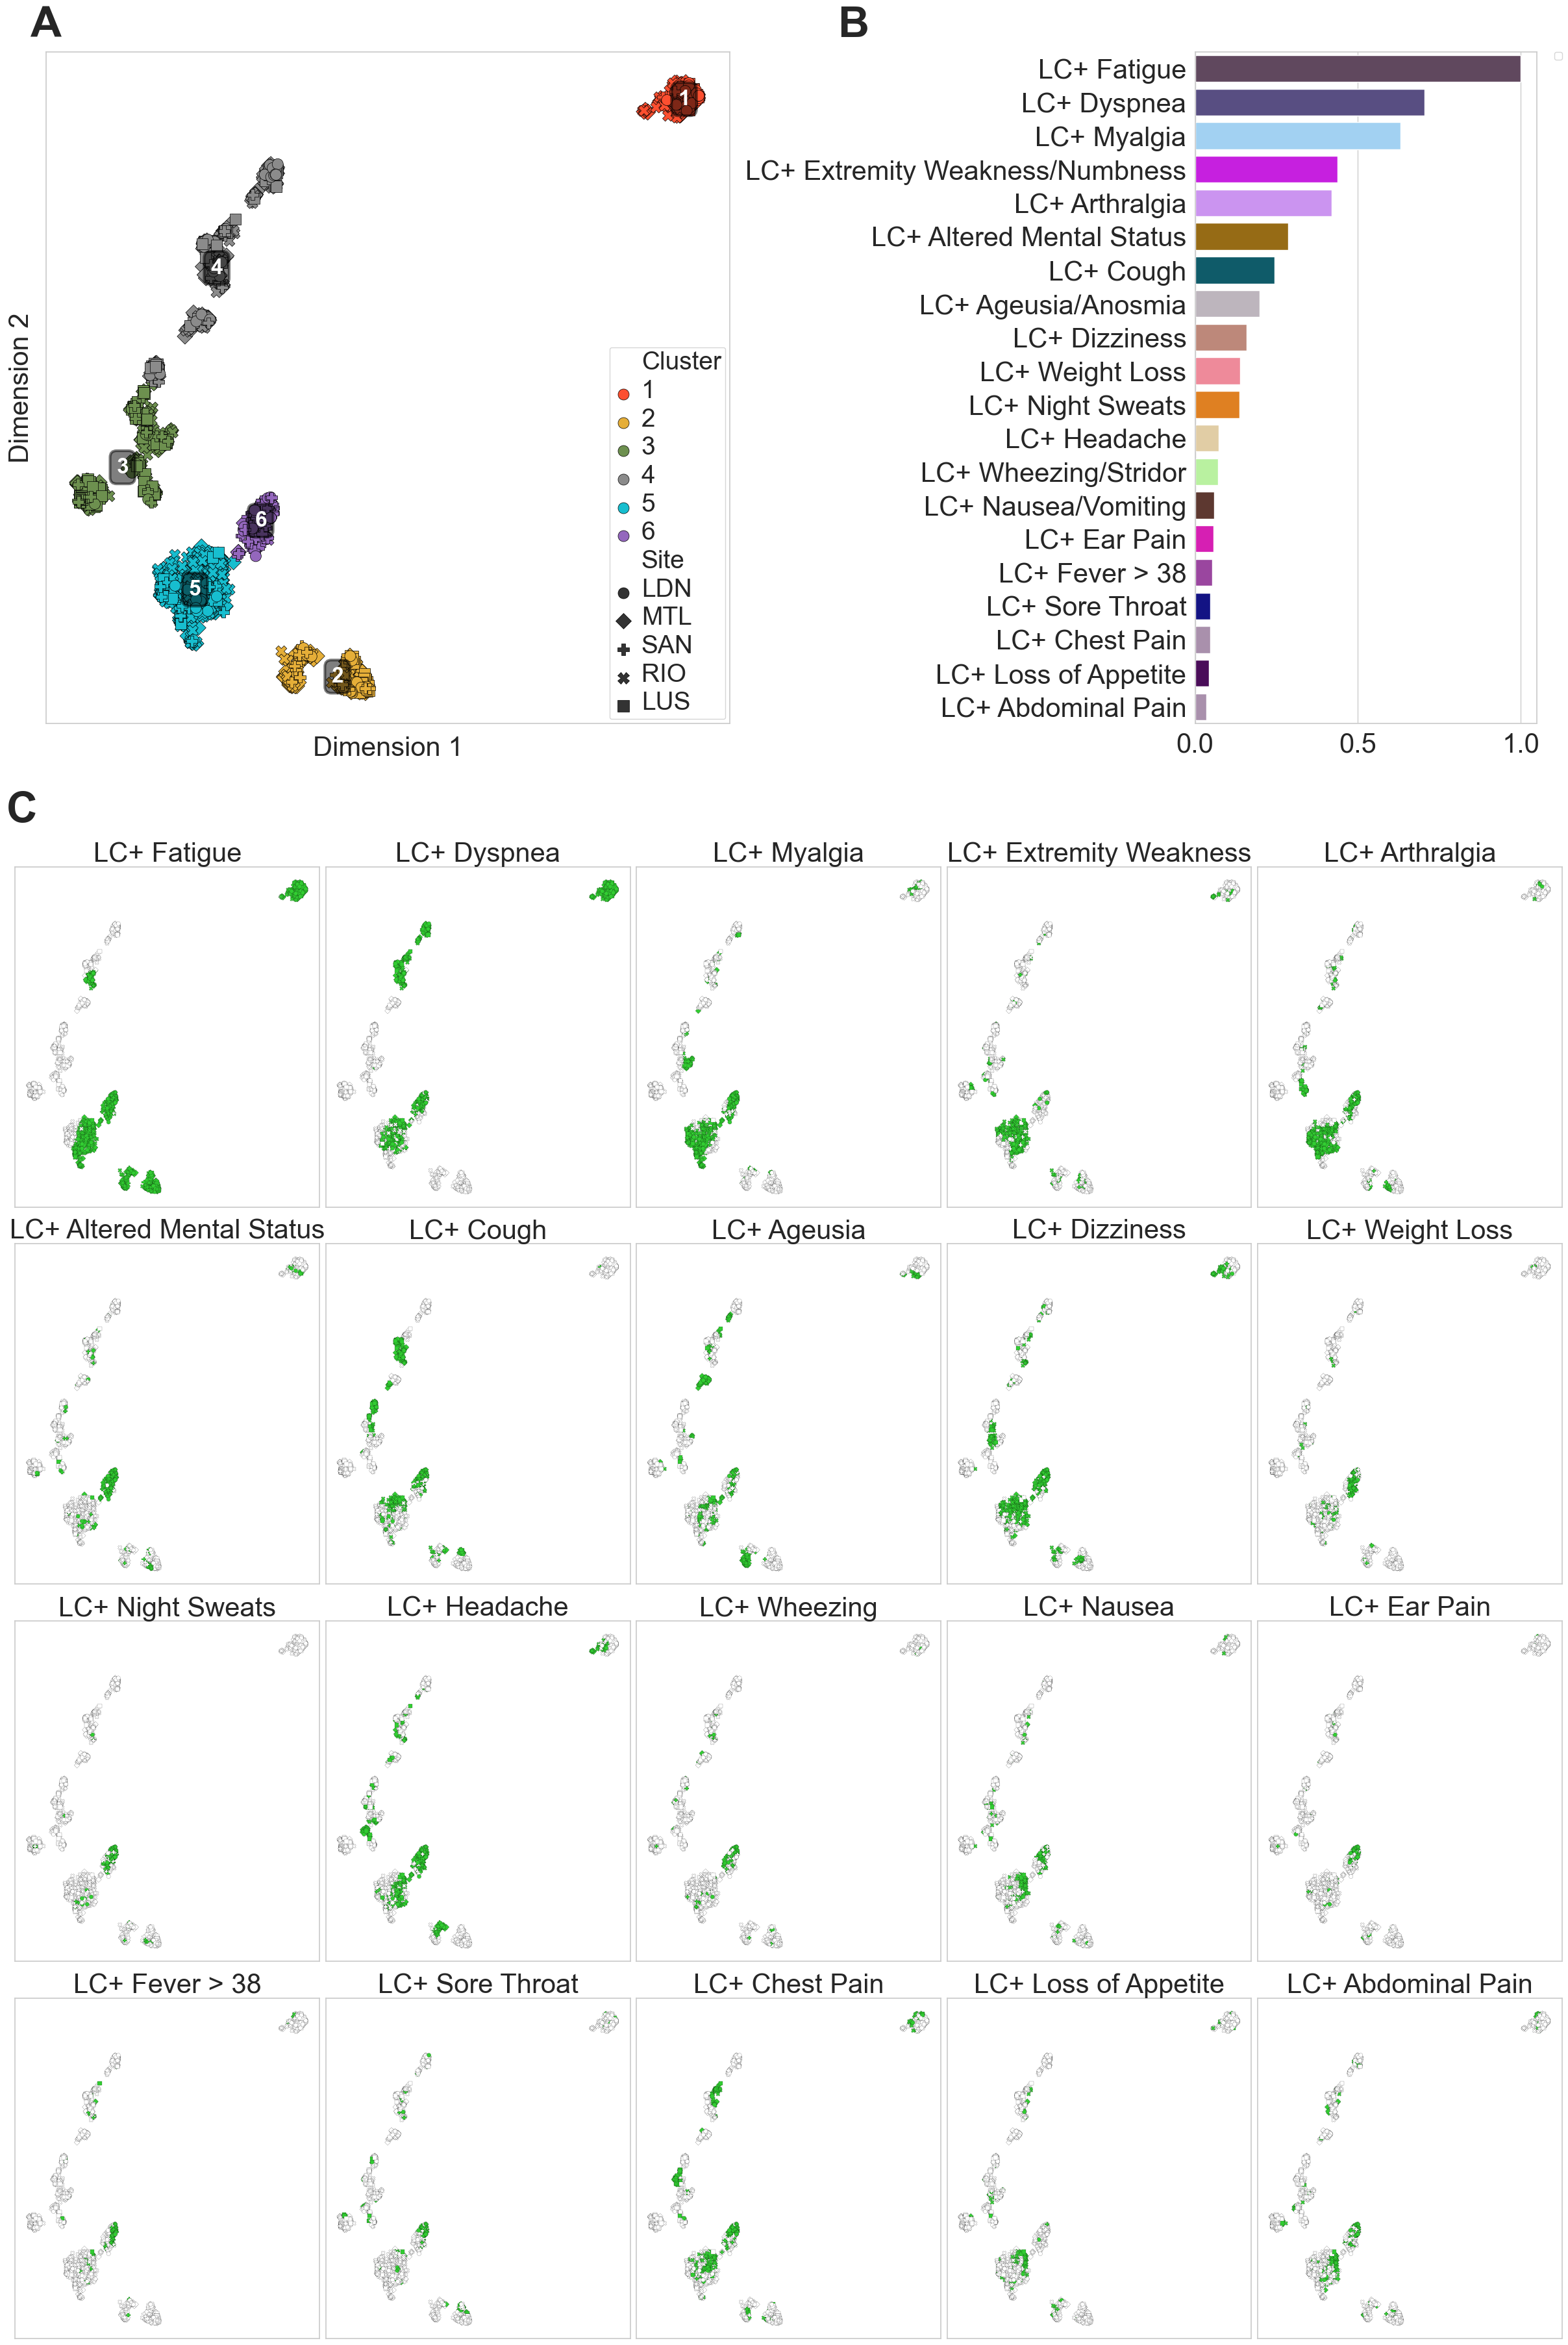

In [210]:
# plot

# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)
n_rows = int(np.ceil(n/5))

# h_factor = 

fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[1,2], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = axs0[0],
              FONTSIZE = FONTSIZE*1.25,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": False},)
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


plot_feature_importances(top_features, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)

axs1 = subfigs[1].subplots(n_rows,5)

plot_multiple_features(fi_df, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        show_centroids = False,
                        fontsize = FONTSIZE*1.25,

                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:

    for dpi in [600, 300]:
        fn = f"{figdir}/SYMPT_2-only-feature-importances-{dpi}-{n_clust}-{timestamp}.png"
        print(fn)
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

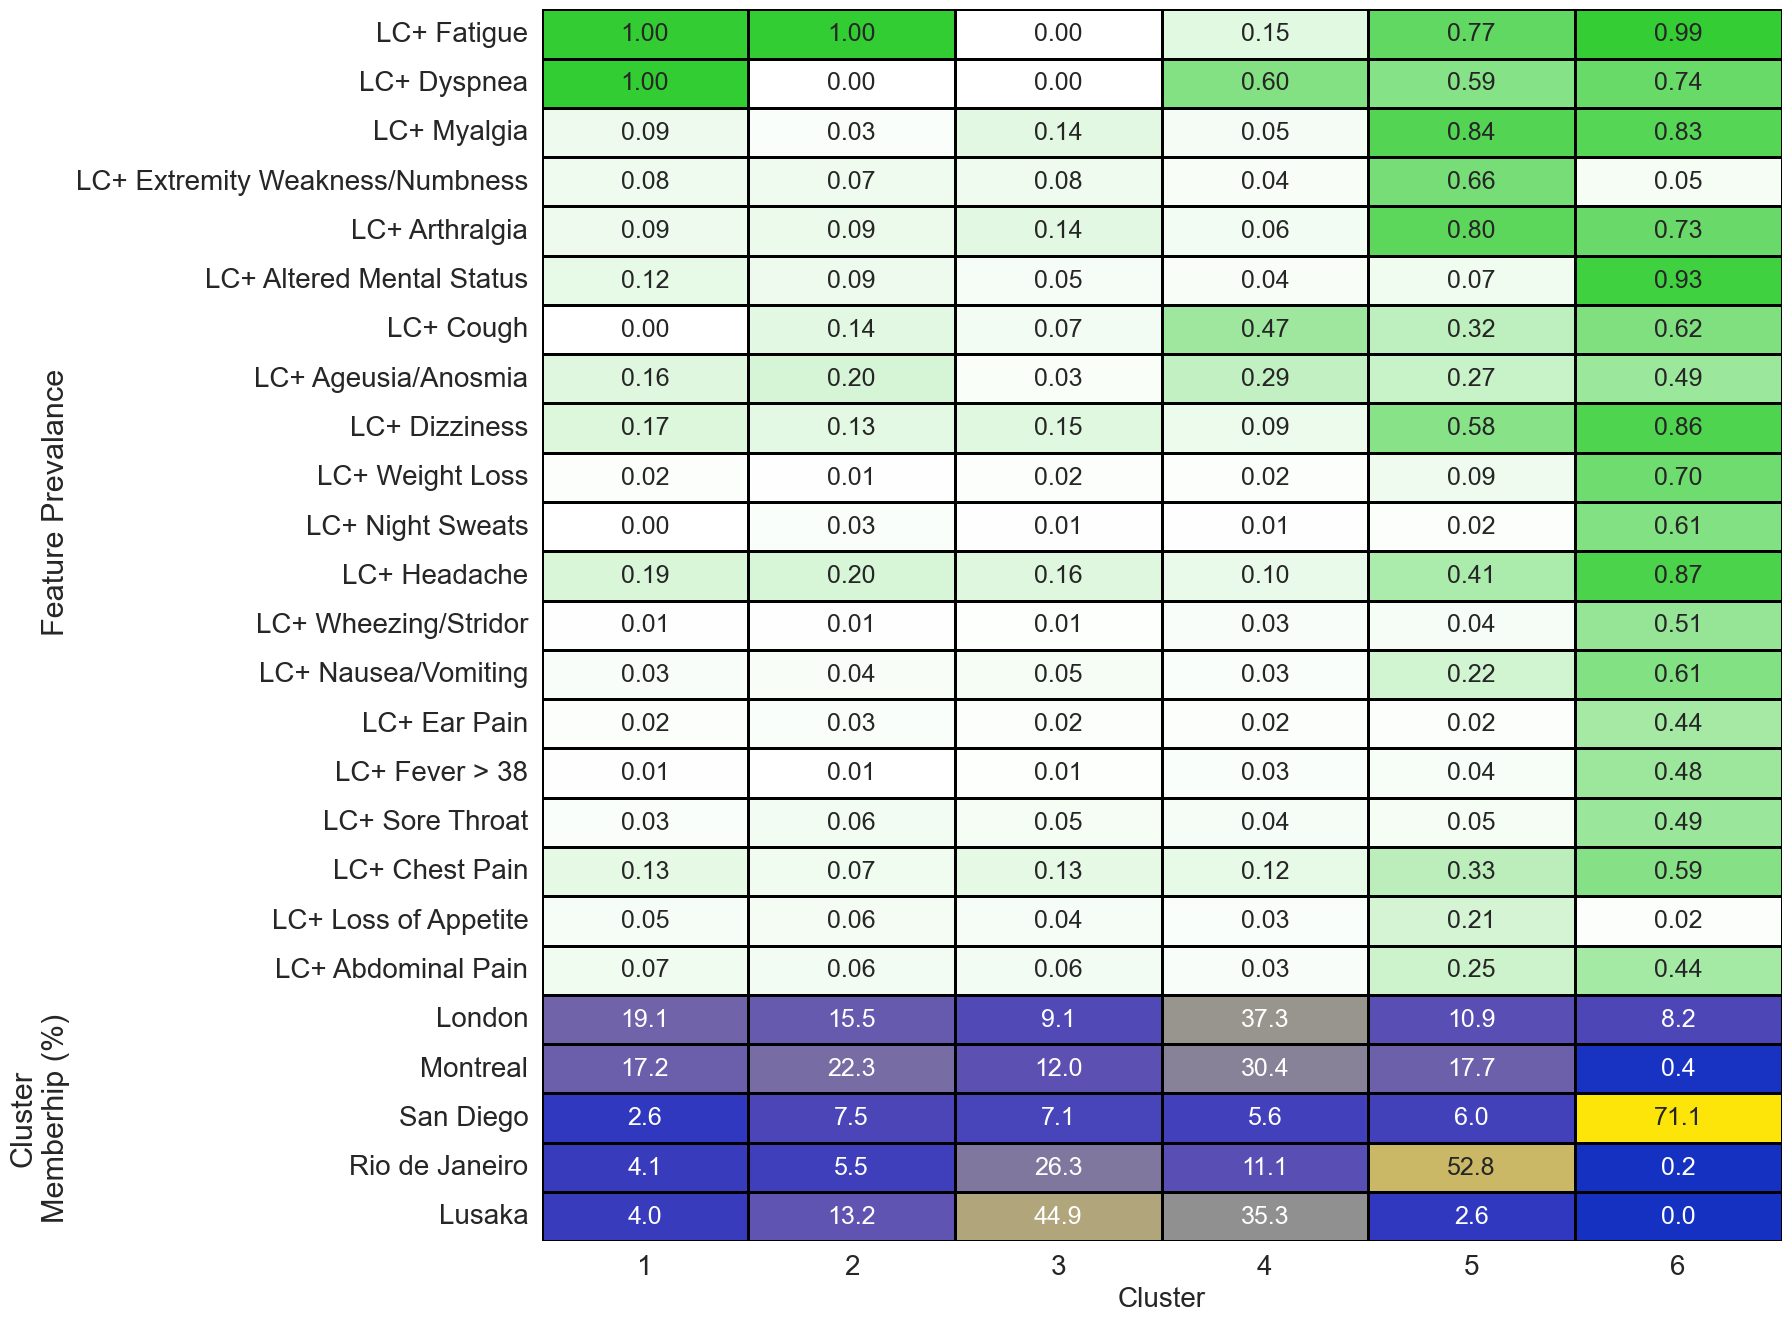

In [211]:
# heatmap of features by cluster
M = X.copy()
M = M[important_features]
M["cluster"] = [c+1 for c in cluster_labels]

# get the means
mfv = M.groupby("cluster").mean()

# sort the index by the order in fi_df
mfv = mfv[fi_df["Feature"]]

# transpose
mfv = mfv.T

# rename mfv index
mfv.index = mfv.index.map(feature_map)


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(16,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

# logscale the heatmap colour
# cmap = sns.color_palette("viridis", as_cmap = True)

from matplotlib.colors import LogNorm

sns.heatmap(mfv[:20], 
            cmap = cmap, 
            # norm = LogNorm(),
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            # norm = LogNorm(),
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')
plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')

# picle mfv
mfv.to_pickle(f"./SYMPT_2-only-feature-prevalence-by-cluster.pkl")


In [212]:
# for each cluster in mfv, find the features that are > 0.3

# make a dataframe to hold the results

# make a dictionary to hold the results
rd = {}

# iterate over the columns in mfv

for c in mfv.columns:
    
        # sort the values in the column
        srt = mfv[c].copy()
        srt.sort_values(ascending = False, inplace = True)

        # print(srt)

        srt_grt = srt[srt > 0.3]


        if len(srt_grt) == 0:
            # get the top 3 features instead
            srt_grt = srt.nlargest(3)


        print(srt_grt.values)

        # get the feature names
        features = srt_grt.index
        values = srt_grt.values
    
        # strip the "LC+" from the feature names
        features = [f.replace("LC+ ", "") for f in features]

        if len(features) > 3:
                features = features[:3]
                values = values[:3]

                # set the last feature to "Other (diffuse)"
                features[-1] = "Others (diffuse)"

                # get the mean value of the other features

                vm = srt_grt.values[3:].mean()
                print(vm)


                # vm = 1

                values[-1] = vm

        # add to the dictionary
        rd.update({c: (features, values)})

# make a dataframe from the dictionary
rd_df2 = pd.DataFrame.from_dict(rd, orient = "index")



[1.         0.99545455]
[1.]
[0.16083916 0.15151515 0.14452214]
[0.60483871 0.46975806]
[0.83612663 0.79515829 0.77281192 0.66108007 0.58659218 0.57914339
 0.40968343 0.33333333 0.31843575]
0.4813780260707636
[0.99014778 0.92610837 0.87192118 0.86206897 0.82758621 0.73891626
 0.73399015 0.7044335  0.62068966 0.60591133 0.60591133 0.591133
 0.51231527 0.49261084 0.48768473 0.48275862 0.44334975 0.43842365
 0.43349754 0.40394089]
0.5873659808751086


In [213]:
rd_df2.reset_index(inplace = True)
# rename the columns
rd_df2.columns = ["Cluster", "Feature", "Value"]
rd_df2

Cluster                                            Feature  \
0        1                                 [Dyspnea, Fatigue]   
1        2                                          [Fatigue]   
2        3                  [Headache, Dizziness, Arthralgia]   
3        4                                   [Dyspnea, Cough]   
4        5            [Myalgia, Arthralgia, Others (diffuse)]   
5        6  [Fatigue, Altered Mental Status, Others (diffu...   

                                               Value  
0                          [1.0, 0.9954545454545455]  
1                                              [1.0]  
2  [0.16083916083916083, 0.15151515151515152, 0.1...  
3          [0.6048387096774194, 0.46975806451612906]  
4  [0.8361266294227188, 0.7951582867783985, 0.481...  
5  [0.9901477832512315, 0.9261083743842364, 0.587...

In [214]:
# save rd_df2 to pickle
rd_df2.to_pickle(f"./SYMPT_2-rd_df2.pkl")

In [215]:
# B = X.copy()

# # augment with site labels
# # B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# new_symp = []

# # iterate over the columns in B, renaming those that are in feature_map
# for c in B.columns:
#     # print(c)
#     # print(list(feature_map.keys()))
#     if c in list(feature_map.keys()):
#         B.rename(columns = {c: feature_map[c]}, inplace = True)
#         new_symp.append(feature_map[c])

# # convert B to boolean
# B = B.astype(bool)

# B["Cluster"] = [c+1 for c in cluster_labels]

# # drop SITE
# # B = B.drop("SITE", axis = 1)

# # save the B dataframe
# # B.to_csv(f"{data_dir}/SYMPT_2-only_RECORDS.csv")



# # # load the B dataframe
# # B = pd.read_csv(f"{data_dir}/SYMPT_2-only_RECORDS.csv", index_col = 0)


# # fig, ax = plt.subplots(1,1, figsize = (16,16))

# us = UpSet(
#     from_indicators(["LC+ Fatigue", "LC+ Dyspnea", "LC+ Myalgia", "LC+ Ageusia/Anosmia", "LC+ Arthralgia", "LC+ Extremity Weakness/Numbness"], data = B),
#     # min_subset_size=100,
#     # max_subset_size=200,
#     intersection_plot_elements = 5,
#     max_subset_rank            = 10,
#     orientation                = "horizontal",
#     # show_counts                = True,
#     show_percentages           = True,
#     sort_by                    = "-degree",
#     sort_categories_by         = "-cardinality",
#     element_size               = 50,
#     # subset_size                = "count",
#     # sum_over                   = "Cluster",
# )

# colors = [cc.glasbey_hv[i] for i in set(B["Cluster"])]

# us.add_stacked_bars(by="Cluster", 
#                        title="Cluster", 
#                        elements=5, 
#                        colors = colors, 
#                        )

# # pr = us.plot(fig)

# us.plot()
# plt.show()

# TREEMAPS
TODO:
- [ ] automate the selection of the top 3 features per cluster
- [ ] build the treemap stuff

In [216]:
# for each cluster in mfv, find the features that are > 0.3

rd = {}

# iterate over the columns in mfv

for c in mfv.columns:
    
        # sort the values in the column
        srt = mfv[c].copy()
        srt.sort_values(ascending = False, inplace = True)

        # find the features that are > 0.3
        srt_grt = srt[srt > 0.3]

        # print(srt_grt)

        # if they are all < 0.3, get the top 3
        if len(srt_grt) == 0:
            # get the top 3 features instead
            srt_grt = srt.nlargest(3)

        # get the feature names
        features = srt_grt.index
    
        # strip the "LC+" from the feature names
        features = [f.replace("LC+ ", "") for f in features]

        # if there are more than 3 features, keep only the top 3
        if len(features) > 3:
                features = features[:3]

                # set the last feature to "Other (diffuse)"
                features[-1] = "Others (diffuse)"

        # add to the dictionary
        rd.update({c: features})

# make a dataframe from the dictionary
rd_df = pd.DataFrame.from_dict(rd, orient = "index")



In [15]:
# summarize cbs by total number of records per cluster
cbs2 = cbs.sum(axis = 0)/cbs.sum().sum()*100

cbs2 = pd.DataFrame(cbs2, columns = ["Fraction"])

# reset the index
cbs2.reset_index(inplace = True)


NameError: name 'cbs' is not defined

In [16]:
s1 = rd_df[0].to_list()
s2 = rd_df[1].to_list()
s3 = rd_df[2].to_list()

cbs2["s1"] = pd.Series(s1)
cbs2["s2"] = pd.Series(s2)
cbs2["s3"] = pd.Series(s3)

NameError: name 'rd_df' is not defined

In [17]:
# add a column to cbs2 that counts the number of symptoms
cbs2["n"] = cbs2["s1"].apply(lambda x: 1 if x != None else 0) + cbs2["s2"].apply(lambda x: 1 if x != None else 0) + cbs2["s3"].apply(lambda x: 1 if x != None else 0)

# round fraction to 1 decimal place
cbs2["Fraction"] = cbs2["Fraction"].round(1)

In [18]:
cbs2["colour"] = [cc.glasbey_dark[i] for i in cbs2["n"]]

# change the value of colour if s3 contains diffuse
idx = cbs2.loc[cbs2["s3"] == "Others (diffuse)"] 

cbs2.loc[idx.index, "colour"] = "#dedbef"


for i, row in cbs2.iterrows():

    # label elements
    l1 = row["s1"]
    if row["s2"] == None:
        l2 = ""
    else:
        l2 = row["s2"]

    if row["s3"] == None:
        l3 = ""
    else:   
        l3 = row["s3"]

    lbl = f"Cluster {i+1}:\n{row['Fraction']:0.1f}%\n{l1}"
    if l2 != "":
        lbl += f"\n{l2}"
    if l3 != "":
        lbl += f"\n{l3}"

    cbs2.loc[i, "label"] = lbl



In [13]:
# get the set of unique feature names in rd_df2["Features"]
features = set()

for i, row in rd_df2.iterrows():
    for f in row["Feature"]:
        features.add(f)

# make a dictionary to hold the results

features

{'Altered Mental Status',
 'Arthralgia',
 'Cough',
 'Dizziness',
 'Dyspnea',
 'Fatigue',
 'Headache',
 'Myalgia',
 'Others (diffuse)'}

In [87]:
data = []

rd_df2["Fraction"] = cbs2["Fraction"]

for i, row in rd_df2.iterrows():

    # print (i,row)

    cluster = row["Cluster"]
    features = row["Feature"]
    values = row["Value"]

    print(cluster, features, values)

    the_dict = {"id": f"Cluster {cluster}",
                "datum": row["Fraction"],
                }

    the_children = []

    for id,datum in zip(features, values):
            
            the_children.append({"id": id,
                                 "datum": datum,
                                })

    the_dict["children"] = the_children
    data.append(the_dict)
data

1 ['Dyspnea', 'Fatigue'] [1.         0.99545455]
2 ['Fatigue'] [1.]
3 ['Headache', 'Dizziness', 'Arthralgia'] [0.16083916 0.15151515 0.14452214]
4 ['Dyspnea', 'Cough'] [0.60483871 0.46975806]
5 ['Myalgia', 'Arthralgia', 'Others (diffuse)'] [0.83612663 0.79515829 0.48137803]
6 ['Fatigue', 'Altered Mental Status', 'Others (diffuse)'] [0.99014778 0.92610837 0.58736598]


[{'id': 'Cluster 1',
  'datum': 10.0,
  'children': [{'id': 'Dyspnea', 'datum': 1.0},
   {'id': 'Fatigue', 'datum': 0.9954545454545455}]},
 {'id': 'Cluster 2',
  'datum': 14.1,
  'children': [{'id': 'Fatigue', 'datum': 1.0}]},
 {'id': 'Cluster 3',
  'datum': 19.6,
  'children': [{'id': 'Headache', 'datum': 0.16083916083916083},
   {'id': 'Dizziness', 'datum': 0.15151515151515152},
   {'id': 'Arthralgia', 'datum': 0.1445221445221445}]},
 {'id': 'Cluster 4',
  'datum': 22.6,
  'children': [{'id': 'Dyspnea', 'datum': 0.6048387096774194},
   {'id': 'Cough', 'datum': 0.46975806451612906}]},
 {'id': 'Cluster 5',
  'datum': 24.5,
  'children': [{'id': 'Myalgia', 'datum': 0.8361266294227188},
   {'id': 'Arthralgia', 'datum': 0.7951582867783985},
   {'id': 'Others (diffuse)', 'datum': 0.4813780260707636}]},
 {'id': 'Cluster 6',
  'datum': 9.3,
  'children': [{'id': 'Fatigue', 'datum': 0.9901477832512315},
   {'id': 'Altered Mental Status', 'datum': 0.9261083743842364},
   {'id': 'Others (diffus

In [88]:
fc2 = {'Dyspnea': [0.32549, 0.270588, 0.545098],
       'Arthralgia': [0.807843, 0.521569, 1.0],
       'Cough': [0.0, 0.4, 0.470588],
       'Fatigue': [0.392157, 0.266667, 0.380392],
       'Dizziness': [0.784314, 0.509804, 0.435294],
       'Headache': [0.921569, 0.815686, 0.607843],
       'Myalgia': [0.584314, 0.827451, 1.0],
       'Altered Mental Status': [0.670588, 0.447059, 0.0],
       'Others (diffuse)': [0.8, 0.8, 0.8],}

In [89]:
# select only keys that start with LC+
feature_colour_map = {k: v for k, v in feature_colour_map.items() if k.startswith("LC+")}

NameError: name 'feature_colour_map' is not defined

In [93]:

import circlify
circles = circlify.circlify(data, show_enclosure=False)


In [95]:

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(16, 16))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

COLOUR_FEATURES = False

if COLOUR_FEATURES:
    node_alpha  = 0.75
    child_alpha = 1.0
else:
    node_alpha   = 1.0
    child_alpha  = 0.5
    child_colour = "white"

# print circles
for i, circle in enumerate(circles):

    x, y, r = circle
    
    print(circle.ex["id"])
    
    if circle.level == 0:
        pass
    if circle.level == 1:
        idx = circle.ex["id"].split(" ")[1]
        the_color = cc.glasbey_hv[int(idx)]
        the_alpha = node_alpha
        font_size = 24
        font_weight = "bold"

        bbox_dict = dict(
                    facecolor=the_color,
                    edgecolor='black', 
                    boxstyle='round', 
                    pad=0.3,
                    linewidth = 1.5)

    if circle.level == 2:

        if COLOUR_FEATURES:
            if circle.ex["id"] in fc2.keys():
                print(f"FOUND {circle.ex['id']} in fc2.keys()")
                # child_color = fc2[circle.ex["id"]]
                the_color = fc2[circle.ex["id"]]
            else:
                the_color = "grey"
        else:
            the_color = child_colour

        the_alpha = child_alpha
        font_size = 18
        font_weight = "normal"

        bbox_dict = dict(
                        facecolor="white", 
                        edgecolor='black', 
                        boxstyle='round', 
                        pad=.2, 
                        alpha = 1.0, 
                        linewidth = 0.5, 
                        )

    # draw the circle
    ax.add_patch(plt.Circle(
                            (x, y), 
                            r, 
                            facecolor = the_color, 
                            alpha     = the_alpha,
                            fill      = True, 
                            ec        = "black",
                            lw        = 2.5,
                            )
                        )

    # add the labels
    if circle.level == 1:

        lbl1 = f"{circle.ex['id']} ({circle.ex['datum']}%)"

        ax.text(x, y+(r*1.0),
                lbl1, 
                ha='center', 
                va='bottom', 
                fontsize=font_size,
                color = "white", 
                fontweight = font_weight,
                bbox=bbox_dict)    

    # child circles
    if circle.level == 2:

        lbl = circle.ex["id"]
        wt  = circle.ex["datum"]

        # if there is a /, split and bnewling
        if "/" in lbl:
            lbl = lbl.split("/")[0] + "/\n" + lbl.split("/")[1]

        # split on spaces and replace with newlines
        lbl = lbl.replace(" ", "\n")
        ax.text(x, y, lbl,
                    ha='center', 
                    va='center', 
                    bbox     = bbox_dict,
                    fontsize = font_size,
        )


for dpi in [300]:

    if COLOUR_FEATURES:
        tag = "coloured-by-feature"
    else:
        tag = "coloured-by-cluster"

    fn = f"{figdir}/TREEMAP-symptoms-{tag}-{dpi}.png"
    print(fn)

    plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


plt.show()

NameError: name 'plt' is not defined

In [118]:
# pickle cbs2
# cbs2.to_pickle(f"./SYMPT_2-only-symptoms-TREEMAP-300-{n_clust}.pkl")

In [1]:
# import pandas as pd
# n_clust = 6


# # load the pickle
# cbs2 = pd.read_pickle(f"./SYMPT_2-only-symptoms-TREEMAP-300-{n_clust}.pkl")

# rd_df2 = pd.read_pickle(f"./SYMPT_2-rd_df2.pkl")

In [3]:
cbs2

cluster  Fraction        s1                     s2                s3  n  \
0        1      10.0   Dyspnea                Fatigue              None  2   
1        2      14.1   Fatigue                   None              None  1   
2        3      19.6  Headache              Dizziness        Arthralgia  3   
3        4      22.6   Dyspnea                  Cough              None  2   
4        5      24.5   Myalgia             Arthralgia  Others (diffuse)  3   
5        6       9.3   Fatigue  Altered Mental Status  Others (diffuse)  3   

    colour                                              label  
0  #018700                Cluster 1:\n10.0%\nDyspnea\nFatigue  
1  #8c3bff                         Cluster 2:\n14.1%\nFatigue  
2  #00acc6  Cluster 3:\n19.6%\nHeadache\nDizziness\nArthra...  
3  #018700                  Cluster 4:\n22.6%\nDyspnea\nCough  
4  #dedbef  Cluster 5:\n24.5%\nMyalgia\nArthralgia\nOthers...  
5  #dedbef  Cluster 6:\n9.3%\nFatigue\nAltered Mental Stat...

### igraph

In [39]:
import pandas as pd
n_clust = 6


# load the pickle
cbs2 = pd.read_pickle(f"./SYMPT_2-only-symptoms-TREEMAP-300-{n_clust}.pkl")

rd_df2 = pd.read_pickle(f"./SYMPT_2-rd_df2.pkl")

In [40]:
# import python igraph
import igraph as ig


In [41]:
# Make a list of tuples that joins the cluster number with the symptom
ee = []
wts = []

for i, row in rd_df2.iterrows():

    cluster = row["Cluster"]
    features = row["Feature"]
    values = row["Value"]

    print(cluster, features, values)

    for f,v in zip(features, values):
        ee.append((f, f"Cluster {cluster}"))
        wts.append(v)

ee, wts

1 ['Dyspnea', 'Fatigue'] [1.         0.99545455]
2 ['Fatigue'] [1.]
3 ['Headache', 'Dizziness', 'Arthralgia'] [0.16083916 0.15151515 0.14452214]
4 ['Dyspnea', 'Cough'] [0.60483871 0.46975806]
5 ['Myalgia', 'Arthralgia', 'Others (diffuse)'] [0.83612663 0.79515829 0.48137803]
6 ['Fatigue', 'Altered Mental Status', 'Others (diffuse)'] [0.99014778 0.92610837 0.58736598]


([('Dyspnea', 'Cluster 1'),
  ('Fatigue', 'Cluster 1'),
  ('Fatigue', 'Cluster 2'),
  ('Headache', 'Cluster 3'),
  ('Dizziness', 'Cluster 3'),
  ('Arthralgia', 'Cluster 3'),
  ('Dyspnea', 'Cluster 4'),
  ('Cough', 'Cluster 4'),
  ('Myalgia', 'Cluster 5'),
  ('Arthralgia', 'Cluster 5'),
  ('Others (diffuse)', 'Cluster 5'),
  ('Fatigue', 'Cluster 6'),
  ('Altered Mental Status', 'Cluster 6'),
  ('Others (diffuse)', 'Cluster 6')],
 [1.0,
  0.9954545454545455,
  1.0,
  0.16083916083916083,
  0.15151515151515152,
  0.1445221445221445,
  0.6048387096774194,
  0.46975806451612906,
  0.8361266294227188,
  0.7951582867783985,
  0.4813780260707636,
  0.9901477832512315,
  0.9261083743842364,
  0.5873659808751086])

In [42]:
g = ig.Graph( directed = True)

src = list(set([e[0] for e in ee]))
tgt = list(set([e[1] for e in ee]))

g.add_vertices(src)
g.add_vertices(tgt)

g.add_edges(ee)

ig.summary(g)

IGRAPH DN-- 15 14 -- 
+ attr: name (v)


In [43]:

# assign name attribute
g.vs["name"] = src + tgt
g.vs["color"] = ["white" if v in src else "grey" for v in g.vs["name"]]

g.vs["size"] = [100 if v in src else 20 for v in g.vs["name"]]

# enumerate the src vertices
src_idx = [g.vs.find(name = s).index for s in src]
tgt_idx = [g.vs.find(name = t).index for t in tgt]
# g.vs[tgt_idx]["name"] = [i+i for i in range(len(tgt))]
# change the colours of the source vertices using the index list

import colorcet as cc
from math import log10

# g.vs[tgt_idx]["color"] = [cc.glasbey_hv[i+1] for i in range(len(tgt))]

clr = []
for i, t in enumerate(tgt):
    the_tgt_idx = t.split(" ")[1]
    clr.append(cc.glasbey_hv[int(the_tgt_idx)])
g.vs[tgt_idx]["color"] = clr

g.vs[tgt_idx]["size"] = [log10(cbs2.loc[i, "Fraction"])*50 for i in range(len(tgt))]
# make a new empty layout object
layout = ig.Layout()

# for each vertex in the graph, assign a position
for i, v in enumerate(g.vs):

    if v["name"] in src:
       layout.append((0, i*120))


# for the target vertices, assign a position
# get the target vertices
tv = [v for v in g.vs if v["name"] not in src]

for i, v in enumerate(tv):
    layout.append((1, i*120))


# # tgt vertex label to the right
# g.vs[tgt_idx]["label_dist"] = 2
# g.vs[tgt_idx]["label_angle"] = 0

# # src vertex label to the left
# g.vs[src_idx]["label_dist"] = 2
# g.vs[src_idx]["label_angle"] = 3.14

# edge weights
g.es["width"] = [w*10 for w in wts]


# make the edge color equal to the target vertex color
g.es["color"] = [g.vs[e.target]["color"] for e in g.es]

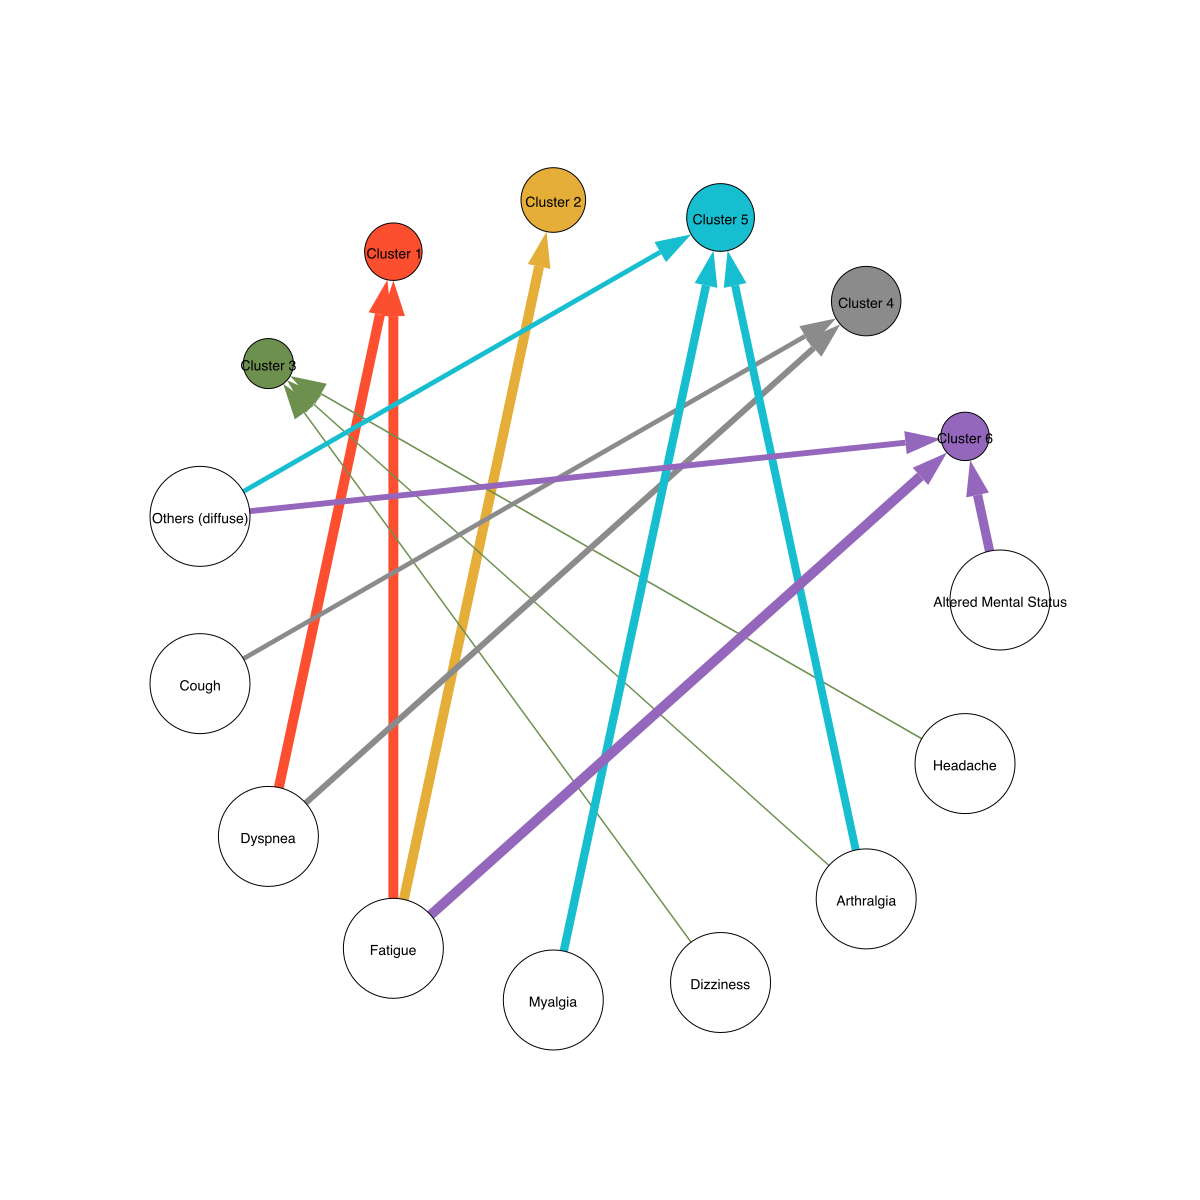

In [44]:
ig.plot(g,
        bbox = (1200, 1200),
        margin = 200,
        # vertex_size = 40,
        vertex_label = g.vs["name"],
        # layout = layout,
        layout = 'circular',
        autocurve = True,

        edge_width = g.es["width"],

        # make arrowhead wider
        edge_arrow_size = 2.5,


        # offset the vertex label to the right

        # vertex_label_dist = 1.5,
        # vertex_label_angle = 0,

        # curve edges
        # edge_curved = 0.3,
)

### for LaTeX

In [168]:
# make an output dir for tex files
from pathlib import Path
texpath = Path("./tex-figures")

if not texpath.exists():
    texpath.mkdir()




In [169]:
fc2 = {'Dyspnea': [0.32549, 0.270588, 0.545098],
       'Arthralgia': [0.807843, 0.521569, 1.0],
       'Cough': [0.0, 0.4, 0.470588],
       'Fatigue': [0.392157, 0.266667, 0.380392],
       'Dizziness': [0.784314, 0.509804, 0.435294],
       'Headache': [0.921569, 0.815686, 0.607843],
       'Myalgia': [0.584314, 0.827451, 1.0],
       'Altered Mental Status': [0.670588, 0.447059, 0.0],
       'Others (diffuse)': [0.8, 0.8, 0.8],}

In [170]:
# get the set of unique feature names in rd_df2["Features"]
features = set()

for i, row in rd_df2.iterrows():
    for f in row["Feature"]:
        features.add(f)

# make a dictionary to hold the results

features

{'Altered Mental Status',
 'Arthralgia',
 'Cough',
 'Dizziness',
 'Dyspnea',
 'Fatigue',
 'Headache',
 'Myalgia',
 'Others (diffuse)'}

In [171]:
rd_df2["Fraction"] = cbs2["Fraction"]

In [172]:
import matplotlib.colors as mcolors

In [173]:
rd_df2

Cluster                                            Feature  \
0        1                                 [Dyspnea, Fatigue]   
1        2                                          [Fatigue]   
2        3                  [Headache, Dizziness, Arthralgia]   
3        4                                   [Dyspnea, Cough]   
4        5            [Myalgia, Arthralgia, Others (diffuse)]   
5        6  [Fatigue, Altered Mental Status, Others (diffu...   

                                               Value  Fraction  
0                          [1.0, 0.9954545454545455]      10.0  
1                                              [1.0]      14.1  
2  [0.16083916083916083, 0.15151515151515152, 0.1...      19.6  
3          [0.6048387096774194, 0.46975806451612906]      22.6  
4  [0.8361266294227188, 0.7951582867783985, 0.481...      24.5  
5  [0.9901477832512315, 0.9261083743842364, 0.587...       9.3

In [174]:
cbs2

cluster  Fraction        s1                     s2                s3  n  \
0        1      10.0   Dyspnea                Fatigue              None  2   
1        2      14.1   Fatigue                   None              None  1   
2        3      19.6  Headache              Dizziness        Arthralgia  3   
3        4      22.6   Dyspnea                  Cough              None  2   
4        5      24.5   Myalgia             Arthralgia  Others (diffuse)  3   
5        6       9.3   Fatigue  Altered Mental Status  Others (diffuse)  3   

    colour                                              label  
0  #018700                Cluster 1:\n10.0%\nDyspnea\nFatigue  
1  #8c3bff                         Cluster 2:\n14.1%\nFatigue  
2  #00acc6  Cluster 3:\n19.6%\nHeadache\nDizziness\nArthra...  
3  #018700                  Cluster 4:\n22.6%\nDyspnea\nCough  
4  #dedbef  Cluster 5:\n24.5%\nMyalgia\nArthralgia\nOthers...  
5  #dedbef  Cluster 6:\n9.3%\nFatigue\nAltered Mental Stat...

In [175]:
# make a new dataframe
cluster_data = pd.DataFrame()

cluster_data["Cluster"] = rd_df2["Cluster"]

# fraction should be converted to the start and stop positions coveriung 180 degrees
cluster_data["start"] = 0
cluster_data["stop"] = 0

# iterate over the clusters

for i, row in rd_df2.iterrows():
    
        # get the cluster number
        cluster = row["Cluster"]

        # get the fraction
        frac = row["Fraction"]

        if i == 0:
            start = 0
            stop = frac
        else:
            start = stop
            stop = start + frac

        print(start, stop)

        cluster_data.loc[i, "start"] = round(start*180/100)
        cluster_data.loc[i, "stop"] = round(stop*180/100)
        cluster_data.loc[i, "mid"] = ((start + stop)/2)*180/100


        # tikz_data.loc[i, "colour"] = cbs2.loc[i, "colour"]

        # convert HTML colour to RGB
        c = mcolors.to_rgb(cbs2.loc[i, "colour"])
        c = [int(255*x) for x in c]

        # tikz_data.loc[i, "COLOUR"] = f"rgb({c[0]}, {c[1]}, {c[2]})"
        cluster_data.loc[i, "COLOUR"] = f"clustercolour{cluster}"
        cluster_data.loc[i, "NW"] = round(frac*180/100)

# make a dictionary to hold the results



# rename the columns
cluster_data.columns = ["LABEL", "START", "END", "MID", "COLOUR","NW"]



# resequence the columns
cluster_data = cluster_data[["START", "END", "MID", "NW","COLOUR", "LABEL"]]

# prepend text to the label
cluster_data["NODENAME"] = cluster_data["LABEL"].apply(lambda x: f"c{x}")
cluster_data["LABEL"] = cluster_data["LABEL"].apply(lambda x: f"Cluster {x}")


0 10.0
10.0 24.1
24.1 43.7
43.7 66.30000000000001
66.30000000000001 90.80000000000001
90.80000000000001 100.10000000000001


In [176]:
cluster_data

START  END     MID    NW          COLOUR      LABEL NODENAME
0      0   18    9.00  18.0  clustercolour1  Cluster 1       c1
1     18   43   30.69  25.0  clustercolour2  Cluster 2       c2
2     43   79   61.02  35.0  clustercolour3  Cluster 3       c3
3     79  119   99.00  41.0  clustercolour4  Cluster 4       c4
4    119  163  141.39  44.0  clustercolour5  Cluster 5       c5
5    163  180  171.81  17.0  clustercolour6  Cluster 6       c6

In [177]:
import colorcet as cc

In [178]:
# write out the cluster colours as tex file

with open(texpath / "cluster_colours.tex", "w") as f:

    for i,row in cluster_data.iterrows():
        c = cc.glasbey_hv[i+1]
        f.write(f"\\definecolor{{clustercolour{i+1}}}{{RGB}}{{{c[0]*255}, {c[1]*255}, {c[2]*255}}}\n")

f.close()

In [179]:
# add the features to the tikz_data dataframe

features_data = pd.DataFrame()

# how many features?
n_features = len(features)

# sort the features
features = sorted(features)


features_data["LABEL"] = [f for f in features]

# features_data["COLOUR"] = [fc2[f] for f in features]

# for i,col in enumerate([fc2[f] for f in features]):
#     c = mcolors.to_rgb(col)
#     c = [int(255*x) for x in c]

#     features_data.loc[i, "COLOUR"] = f"rgb({c[0]}, {c[1]}, {c[2]})"


for i in range(n_features):
    start = 180/n_features*i + 180
    end  = 180/n_features*(i+1) + 180

    features_data.loc[i, "START"] = start
    features_data.loc[i, "END"] = end
    features_data.loc[i, "MID"] = (start + end)/2

    features_data.loc[i, "NW"] = 180/n_features

    # features_data.loc[i, "COLOUR"] = "gray"
    features_data.loc[i, "COLOUR"] = f"featurecolour{i+1}"

    features_data.loc[i,"NODENAME"] = f"f{i+1}"


# resequence
features_data = features_data[["START", "END", "MID", "NW", "COLOUR","LABEL","NODENAME"]]


In [180]:
# write out the cluster colours as tex file

with open(texpath / "feature_colours.tex", "w") as f:

    for i,row in features_data.iterrows():
        c = fc2[row["LABEL"]]
        f.write(f"\\definecolor{{featurecolour{i+1}}}{{RGB}}{{{c[0]*255}, {c[1]*255}, {c[2]*255}}}\n")

f.close()

In [190]:
# stack with the tikz_data dataframe
tikz_data = pd.concat([cluster_data, features_data], axis = 0)

cluster_data.to_csv(texpath / "nodes-cluster.csv", index = False)
features_data.to_csv(texpath / "nodes-symptom.csv", index = False)

# save as a csv
tikz_data.to_csv(texpath / "nodes-cluster-x-symptoms.csv", index = False)

In [182]:
tikz_data

START    END     MID    NW          COLOUR                  LABEL NODENAME
0    0.0   18.0    9.00  18.0  clustercolour1              Cluster 1       c1
1   18.0   43.0   30.69  25.0  clustercolour2              Cluster 2       c2
2   43.0   79.0   61.02  35.0  clustercolour3              Cluster 3       c3
3   79.0  119.0   99.00  41.0  clustercolour4              Cluster 4       c4
4  119.0  163.0  141.39  44.0  clustercolour5              Cluster 5       c5
5  163.0  180.0  171.81  17.0  clustercolour6              Cluster 6       c6
0  180.0  200.0  190.00  20.0  featurecolour1  Altered Mental Status       f1
1  200.0  220.0  210.00  20.0  featurecolour2             Arthralgia       f2
2  220.0  240.0  230.00  20.0  featurecolour3                  Cough       f3
3  240.0  260.0  250.00  20.0  featurecolour4              Dizziness       f4
4  260.0  280.0  270.00  20.0  featurecolour5                Dyspnea       f5
5  280.0  300.0  290.00  20.0  featurecolour6                Fatigue       f6
6  300.0  320.0  310.00  20.0  featurecolour7               Headache       f7
7  320.0  340.0  330.00  20.0  featurecolour8                Myalgia       f8
8  340.0  360.0  350.00  20.0  featurecolour9       Others (diffuse)       f9

In [183]:
edges_df = pd.DataFrame()
edge_dict = {}

edges_list = []


for edge, weight in zip(ee, wts):
    s = edge[0]
    t = edge[1]

    print(edge)

    w = weight

    # look up the mid points


    mids = tikz_data.loc[tikz_data['LABEL'] == s]["MID"].values[0]
    midt = tikz_data.loc[tikz_data['LABEL'] == t]["MID"].values[0]

    ns = tikz_data.loc[tikz_data['LABEL'] == s]["NODENAME"].values[0]
    nt = tikz_data.loc[tikz_data['LABEL'] == t]["NODENAME"].values[0]
    
    print(ns,nt)

    if mids > 270.00:
        side = "left"
    else:
        side = "right"
    

      
    edge_string = f"({ns}) to [bend {side}={int(w*10)}] ({nt})"

    print(edge_string)

    dd = (mids, midt, side, int(w*10), ns, nt, edge_string)


    edges_list.append(dd)

# make a dataframe from the list of tuples
edges_df = pd.DataFrame(edges_list, columns = ["ESTART", "EEND", "BENDDIR", "WIDTH","NODESTART", "NODEEND","EDGESTRING"])
edges_df

('Dyspnea', 'Cluster 1')
f5 c1
(f5) to [bend right=10] (c1)
('Fatigue', 'Cluster 1')
f6 c1
(f6) to [bend left=9] (c1)
('Fatigue', 'Cluster 2')
f6 c2
(f6) to [bend left=10] (c2)
('Headache', 'Cluster 3')
f7 c3
(f7) to [bend left=1] (c3)
('Dizziness', 'Cluster 3')
f4 c3
(f4) to [bend right=1] (c3)
('Arthralgia', 'Cluster 3')
f2 c3
(f2) to [bend right=1] (c3)
('Dyspnea', 'Cluster 4')
f5 c4
(f5) to [bend right=6] (c4)
('Cough', 'Cluster 4')
f3 c4
(f3) to [bend right=4] (c4)
('Myalgia', 'Cluster 5')
f8 c5
(f8) to [bend left=8] (c5)
('Arthralgia', 'Cluster 5')
f2 c5
(f2) to [bend right=7] (c5)
('Others (diffuse)', 'Cluster 5')
f9 c5
(f9) to [bend left=4] (c5)
('Fatigue', 'Cluster 6')
f6 c6
(f6) to [bend left=9] (c6)
('Altered Mental Status', 'Cluster 6')
f1 c6
(f1) to [bend right=9] (c6)
('Others (diffuse)', 'Cluster 6')
f9 c6
(f9) to [bend left=5] (c6)


ESTART    EEND BENDDIR  WIDTH NODESTART NODEEND  \
0    270.0    9.00   right     10        f5      c1   
1    290.0    9.00    left      9        f6      c1   
2    290.0   30.69    left     10        f6      c2   
3    310.0   61.02    left      1        f7      c3   
4    250.0   61.02   right      1        f4      c3   
5    210.0   61.02   right      1        f2      c3   
6    270.0   99.00   right      6        f5      c4   
7    230.0   99.00   right      4        f3      c4   
8    330.0  141.39    left      8        f8      c5   
9    210.0  141.39   right      7        f2      c5   
10   350.0  141.39    left      4        f9      c5   
11   290.0  171.81    left      9        f6      c6   
12   190.0  171.81   right      9        f1      c6   
13   350.0  171.81    left      5        f9      c6   

                      EDGESTRING  
0   (f5) to [bend right=10] (c1)  
1     (f6) to [bend left=9] (c1)  
2    (f6) to [bend left=10] (c2)  
3     (f7) to [bend left=1] (c3)  
4    (f4) to [bend right=1] (c3)  
5    (f2) to [bend right=1] (c3)  
6    (f5) to [bend right=6] (c4)  
7    (f3) to [bend right=4] (c4)  
8     (f8) to [bend left=8] (c5)  
9    (f2) to [bend right=7] (c5)  
10    (f9) to [bend left=4] (c5)  
11    (f6) to [bend left=9] (c6)  
12   (f1) to [bend right=9] (c6)  
13    (f9) to [bend left=5] (c6)

In [187]:
# save edges_df as csv, without index
edges_df.to_csv(texpath / "edges-cluster-x-symptoms.csv", index = False)

In [185]:
s2 = pd.read_pickle("SYMPT_2-only-feature-prevalence-by-cluster.pkl")


In [186]:
s2

cluster                                 1         2         3         4  \
LC+ Fatigue                      0.995455  1.000000  0.000000  0.147177   
LC+ Dyspnea                      1.000000  0.000000  0.002331  0.604839   
LC+ Myalgia                      0.090909  0.025890  0.139860  0.052419   
LC+ Extremity Weakness/Numbness  0.081818  0.074434  0.079254  0.036290   
LC+ Arthralgia                   0.090909  0.093851  0.144522  0.060484   
LC+ Altered Mental Status        0.118182  0.090615  0.046620  0.036290   
LC+ Cough                        0.004545  0.142395  0.065268  0.469758   
LC+ Ageusia/Anosmia              0.163636  0.200647  0.027972  0.294355   
LC+ Dizziness                    0.168182  0.132686  0.151515  0.088710   
LC+ Weight Loss                  0.018182  0.012945  0.016317  0.018145   
LC+ Night Sweats                 0.000000  0.025890  0.013986  0.012097   
LC+ Headache                     0.186364  0.197411  0.160839  0.102823   
LC+ Wheezing/Stridor             0.013636  0.012945  0.009324  0.032258   
LC+ Nausea/Vomiting              0.031818  0.038835  0.048951  0.026210   
LC+ Ear Pain                     0.018182  0.025890  0.020979  0.018145   
LC+ Fever > 38                   0.013636  0.006472  0.009324  0.026210   
LC+ Sore Throat                  0.027273  0.061489  0.048951  0.044355   
LC+ Chest Pain                   0.127273  0.067961  0.128205  0.118952   
LC+ Loss of Appetite             0.045455  0.055016  0.044289  0.026210   
LC+ Abdominal Pain               0.068182  0.061489  0.062937  0.034274   
LC+ Edema                        0.054545  0.048544  0.065268  0.018145   
LC+ Diarrhea                     0.086364  0.067961  0.023310  0.026210   
LC+ Skin Rash                    0.050000  0.022654  0.037296  0.034274   

cluster                                 5         6  
LC+ Fatigue                      0.772812  0.990148  
LC+ Dyspnea                      0.586592  0.738916  
LC+ Myalgia                      0.836127  0.827586  
LC+ Extremity Weakness/Numbness  0.661080  0.049261  
LC+ Arthralgia                   0.795158  0.733990  
LC+ Altered Mental Status        0.067039  0.926108  
LC+ Cough                        0.318436  0.620690  
LC+ Ageusia/Anosmia              0.266294  0.487685  
LC+ Dizziness                    0.579143  0.862069  
LC+ Weight Loss                  0.085661  0.704433  
LC+ Night Sweats                 0.016760  0.605911  
LC+ Headache                     0.409683  0.871921  
LC+ Wheezing/Stridor             0.044693  0.512315  
LC+ Nausea/Vomiting              0.223464  0.605911  
LC+ Ear Pain                     0.022346  0.438424  
LC+ Fever > 38                   0.042831  0.482759  
LC+ Sore Throat                  0.050279  0.492611  
LC+ Chest Pain                   0.333333  0.591133  
LC+ Loss of Appetite             0.214153  0.019704  
LC+ Abdominal Pain               0.249534  0.443350  
LC+ Edema                        0.124767  0.433498  
LC+ Diarrhea                     0.143389  0.403941  
LC+ Skin Rash                    0.162011  0.221675

In [167]:
# 